**IMAGE CLASSIFICATION USING THE BENCHMARK DATASET: NON-FL versus FL**

The dataset used for this code was sourced from Kaggle: Segmented Intrusion Detection Dataset (SIDD) - https://www.kaggle.com/datasets/yuweisunut/sidd-segmented-intrusion-detection-dataset. It comprises of benign and malicious images derived from network traffic protocol communications. Due to the large size of the dataset, only data from a single node, specifically n005, was utilized. Additionally, as this is a benchmark dataset serving as a reference for the industrial dataset, using the entire dataset was not required. This image dataset has been included along with other submission documents.

**MOUNTING GOOGLE DRIVE WITH THIS NOTEBOOK**

In [1]:
# Importing the necessary library to connect to Google Drive
from google.colab import drive

# Mounting Google Drive to access the dataset
# This will prompt to authorize access to your Google Drive.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**INSTALLING AND IMPORTING NECESSARY LIBRARIES**

In [2]:
# Importing the warnings library to handle warning messages
import warnings

# Ignoring all warning messages to keep the output clean
# This is helpful to focus on the core output of the code without any distractions.
warnings.filterwarnings('ignore')

In [3]:
# Installing the Flower library along with its optional dependencies for simulation

# Installing the base Flower package
!pip install flwr

# Installing Flower with simulation dependencies
# These include torch, torchvision, and matplotlib for federated learning simulations and data visualization.
!pip install -q flwr[simulation]

# Additional installation of vision-related datasets and PyTorch utilities
# - flwr[simulation]: Flower package with additional dependencies for simulation.
# - flwr_datasets[vision]: Flower datasets package with vision-related datasets.
# - torch: PyTorch, a popular deep learning framework.
# - torchvision: Utility functions for computer vision data processing in PyTorch.
# - matplotlib: Library for data visualization and creating plots.

# The -q flag is used to install the packages quietly, suppressing output except for errors.
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

# Installing the torchviz library for visualizing PyTorch model architectures
# torchviz: A tool to create visual representations of PyTorch model graphs.
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.6/523.6 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.69.0
    Uninstalling grpcio-1.69.0:
      Successfully uninstalled grpcio-1.69.0
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Importing necessary libraries

# Standard libraries for data manipulation and file operations
import os
import shutil
import random
import re
from collections import defaultdict, OrderedDict
from typing import List

# Data handling and processing libraries
import pandas as pd
import numpy as np

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

# PyTorch vision libraries for handling image data
from torchvision import datasets, transforms, models

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import seaborn as sns
import cv2
from PIL import Image

# Scikit-learn libraries for metrics and utility functions
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
)

# Flower libraries for federated learning
import flwr as fl
from flwr.common import Context, parameters_to_ndarrays, ndarrays_to_parameters
from flwr.server.strategy import FedAvg

**SETTING THE DEVICE FOR EXECUTION**

In [5]:
# Setting the device for training: 'cuda' for GPU or 'cpu' for CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Displaying the chosen device along with the PyTorch and Flower library versions
# Ensures the user is aware of the environment configuration.
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.5.1+cu121 and Flower 1.14.0


**CREATION OF TEST DATASET**

In [ ]:
# Function to create a test dataset from given training and validation datasets
# This function should be executed only once to avoid altering the dataset repeatedly.

def create_test_set(train_dir, val_dir, test_dir, n_test_malicious, n_test_benign):
    # Create directories for the test set (malicious and benign) if they don't already exist
    os.makedirs(os.path.join(test_dir, 'malicious'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'benign'), exist_ok=True)

    # Retrieve lists of images from training and validation directories
    train_malicious = os.listdir(os.path.join(train_dir, 'malicious'))
    train_benign = os.listdir(os.path.join(train_dir, 'benign'))
    val_malicious = os.listdir(os.path.join(val_dir, 'malicious'))
    val_benign = os.listdir(os.path.join(val_dir, 'benign'))

    # Shuffle the image lists to ensure randomness in selection
    random.shuffle(train_malicious)
    random.shuffle(train_benign)
    random.shuffle(val_malicious)
    random.shuffle(val_benign)

    # Determine how many malicious images to move from training and validation sets
    test_malicious_from_train = min(n_test_malicious, len(train_malicious))
    test_malicious_from_val = n_test_malicious - test_malicious_from_train

    # Move the selected malicious images to the test set directory
    for img in train_malicious[:test_malicious_from_train]:
        shutil.move(os.path.join(train_dir, 'malicious', img), os.path.join(test_dir, 'malicious', img))
    for img in val_malicious[:test_malicious_from_val]:
        shutil.move(os.path.join(val_dir, 'malicious', img), os.path.join(test_dir, 'malicious', img))

    # Determine how many benign images to move from training and validation sets
    test_benign_from_train = min(n_test_benign, len(train_benign))
    test_benign_from_val = n_test_benign - test_benign_from_train

    # Move the selected benign images to the test set directory
    for img in train_benign[:test_benign_from_train]:
        shutil.move(os.path.join(train_dir, 'benign', img), os.path.join(test_dir, 'benign', img))
    for img in val_benign[:test_benign_from_val]:
        shutil.move(os.path.join(val_dir, 'benign', img), os.path.join(test_dir, 'benign', img))

# Parameters for the directories and number of images for the test set
train_dir = '/content/drive/MyDrive/Training_data'  # Path to the training data directory
val_dir = '/content/drive/MyDrive/Validation_data'  # Path to the validation data directory
test_dir = '/content/drive/MyDrive/Test_data'       # Path to the test data directory

# Number of malicious and benign images to include in the test set
n_test_malicious = 65
n_test_benign = 65

# Execute the function to create the test dataset
create_test_set(train_dir, val_dir, test_dir, n_test_malicious, n_test_benign)

**DATA PRE-PROCESSING**

In [ ]:
# Define the directory paths for benign and malicious images
benign_dir = '/content/drive/MyDrive/Training_data/benign'
malicious_dir = '/content/drive/MyDrive/Training_data/malicious'

# Function to load images and their labels into a DataFrame
def load_image_data(benign_path, malicious_path):
    """
    Load image paths and corresponding labels into a DataFrame.

    Parameters:
    - benign_path (str): Directory path containing benign images.
    - malicious_path (str): Directory path containing malicious images.

    Returns:
    - df (DataFrame): A DataFrame with image paths and their respective labels.
    """
    image_data = []

    # Load benign images into the DataFrame
    for img_name in os.listdir(benign_path):
        img_path = os.path.join(benign_path, img_name)
        image_data.append((img_path, 'benign'))

    # Load malicious images into the DataFrame
    for img_name in os.listdir(malicious_path):
        img_path = os.path.join(malicious_path, img_name)
        image_data.append((img_path, 'malicious'))

    # Create and return a DataFrame with image paths and labels
    df = pd.DataFrame(image_data, columns=['Image_Path', 'Label'])
    return df

# Load the image data into a DataFrame using the function
df = load_image_data(benign_dir, malicious_dir)

# Display the first five rows of the DataFrame to verify the loaded data
print(df.head())

                                          Image_Path   Label
0  /content/drive/MyDrive/Training_data/benign/b ...  benign
1  /content/drive/MyDrive/Training_data/benign/b ...  benign
2  /content/drive/MyDrive/Training_data/benign/b ...  benign
3  /content/drive/MyDrive/Training_data/benign/b ...  benign
4  /content/drive/MyDrive/Training_data/benign/b ...  benign


**IMAGE CONTOURS**

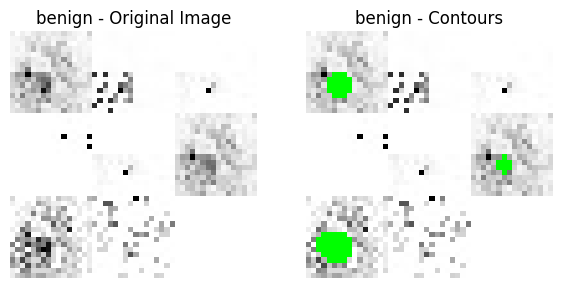

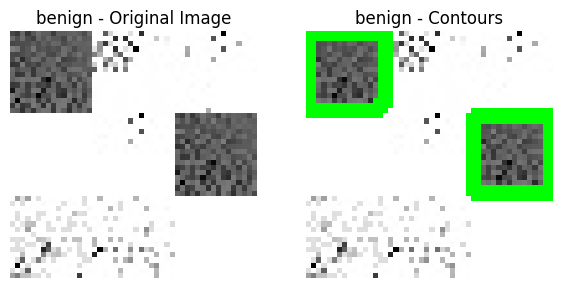

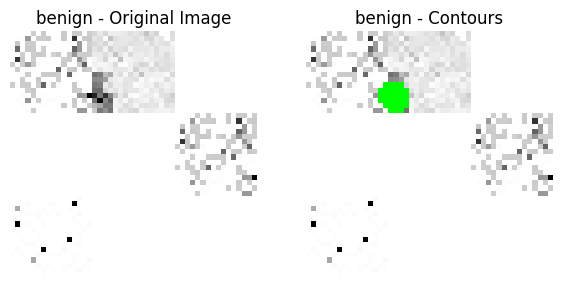

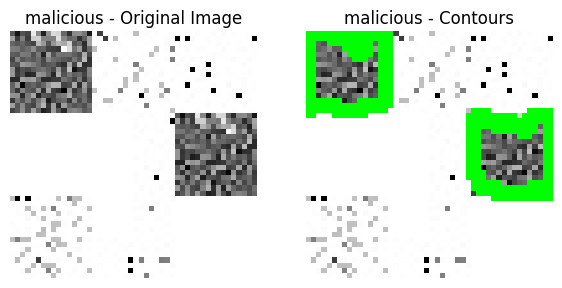

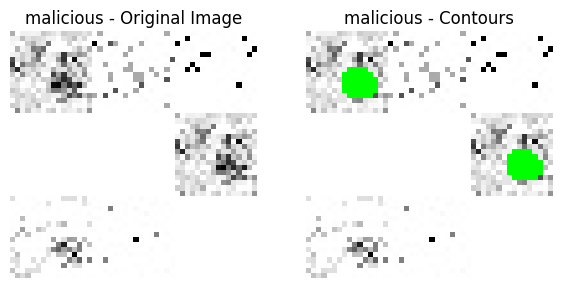

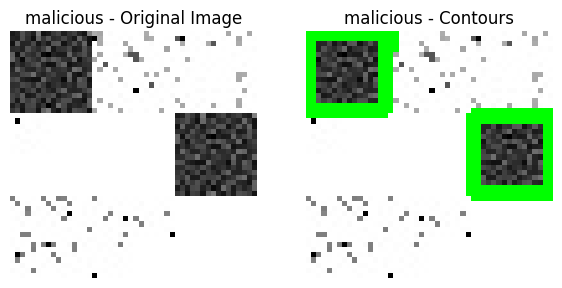

In [ ]:
# Function to analyze and visualize image contours for detecting defects in black and white images
def analyze_image_contours_bw(df, num_images=5):
    """
    Analyzes and visualizes contours of black and white images labeled as 'benign' and 'malicious' from the provided DataFrame.

    This function samples a few images from each category, processes them to find contours,
    and displays the original and contour-detected images side by side.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
                           Assumes columns 'Image_Path' and 'Label' exist in the DataFrame.
        num_images (int): Number of images to sample and analyze from each category (default: 5).
    """
    # Ensure the DataFrame has 'benign' and 'malicious' labels
    if 'benign' not in df['Label'].values:
        print("Warning: No 'benign' images found in the DataFrame.")
    if 'malicious' not in df['Label'].values:
        print("Warning: No 'malicious' images found in the DataFrame.")

    # Ensure the number of samples doesn't exceed available images in each category
    num_images_benign = min(num_images, len(df[df['Label'] == 'benign']))
    num_images_malicious = min(num_images, len(df[df['Label'] == 'malicious']))

    if num_images_benign == 0 and num_images_malicious == 0:
        print("Error: No images available in both 'benign' and 'malicious' categories.")
        return
    elif num_images_benign == 0:
        print("Error: No images available in 'benign' category.")
        return
    elif num_images_malicious == 0:
        print("Error: No images available in 'malicious' category.")
        return

    # Sample images from each category ('benign' and 'malicious')
    df_ok = df[df['Label'] == 'benign'].sample(n=num_images_benign)
    df_nok = df[df['Label'] == 'malicious'].sample(n=num_images_malicious)

    # Function to process and display a single image with contours
    def process_image_bw(image_path, label):
        """
        Processes a single black and white image to find and visualize contours.

        Args:
            image_path (str): Path to the image file.
            label (str): Label indicating the category of the image ('benign' or 'malicious').
        """
        # Read the image from the given path
        if not os.path.exists(image_path):
            print(f"Error: Image path does not exist: {image_path}")
            return

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Error: Unable to read image at {image_path}")
            return

        # Apply Gaussian blur to reduce noise and improve contour detection
        blur = cv2.GaussianBlur(img, (5, 5), 0)

        # Apply binary thresholding to create a binary image
        _, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY_INV)

        # Find contours in the binary image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Copy the original image to draw contours on it (converted to BGR for visualization)
        contour_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)  # Draw green contours

        # Display the original and contour images side by side
        plt.figure(figsize=(7, 5))

        # Display the original image
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} - Original Image')
        plt.axis('off')

        # Display the image with contours
        plt.subplot(1, 2, 2)
        plt.imshow(contour_img)
        plt.title(f'{label} - Contours')
        plt.axis('off')

        plt.show()

    # Analyze images labeled as 'benign'
    for _, row in df_ok.iterrows():
        process_image_bw(row['Image_Path'], 'benign')

    # Analyze images labeled as 'malicious'
    for _, row in df_nok.iterrows():
        process_image_bw(row['Image_Path'], 'malicious')

# Analyze image contours and defects by sampling 3 images from each category
analyze_image_contours_bw(df, num_images=3)


**CANNY EDGE DETECTION**

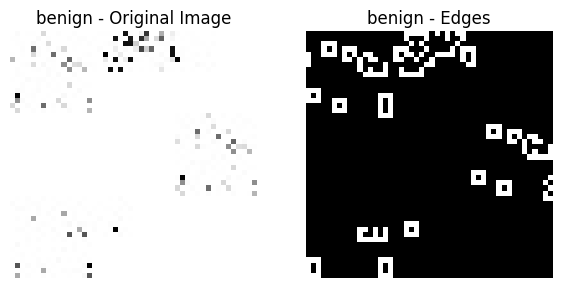

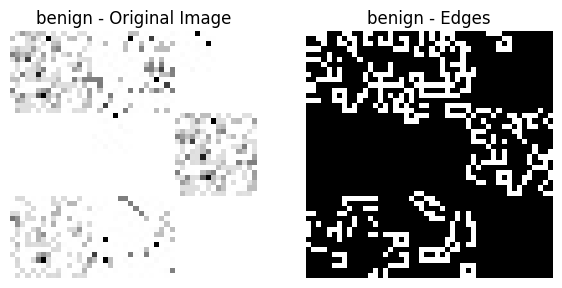

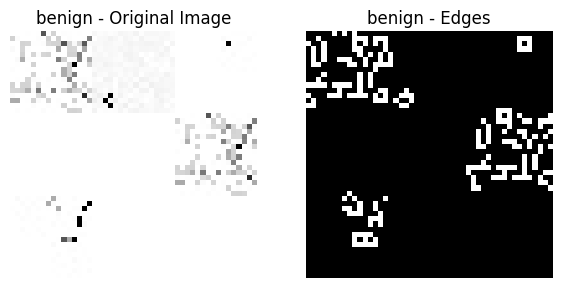

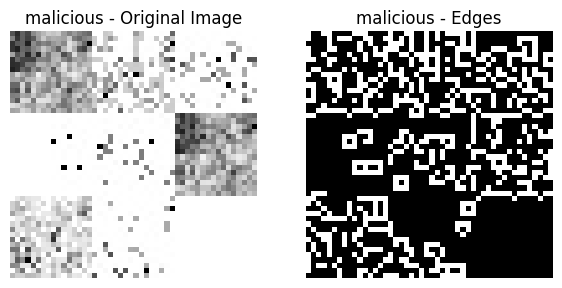

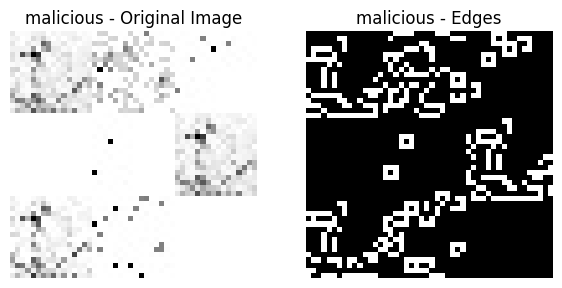

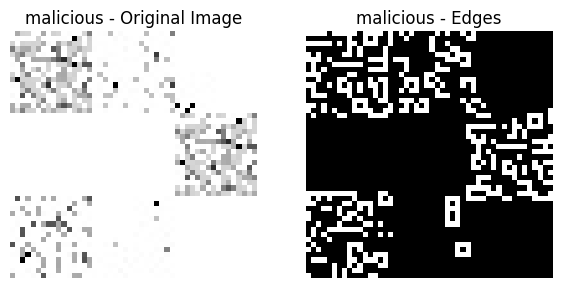

In [ ]:
# Function to visualize edges and detect defects in black and white images using Canny edge detection
def visualize_edges_bw(df, num_images=5):
    """
    Visualizes edges in images labeled as 'benign' and 'malicious' from the provided DataFrame using Canny edge detection.
    Displays the original and edge-detected images side by side for a few samples from each category.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
                           Assumes columns 'Image_Path' and 'Label' exist in the DataFrame.
        num_images (int): Number of images to sample and visualize from each category (default: 5).
    """
    # Sample a few images from each category ('benign' and 'malicious')
    # If there are fewer images than requested, it will sample as many as possible.
    df_benign = df[df['Label'] == 'benign'].sample(n=min(num_images, len(df[df['Label'] == 'benign'])))
    df_malicious = df[df['Label'] == 'malicious'].sample(n=min(num_images, len(df[df['Label'] == 'malicious'])))

    # Internal function to process and display edges of a single image
    def process_image_bw(image_path, label):
        """
        Processes an image to detect and visualize edges using Canny edge detection.

        Args:
            image_path (str): Path to the image file.
            label (str): Label indicating the category of the image ('benign' or 'malicious').
        """
        # Read the image from the specified path in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Error: Unable to read image at {image_path}")
            return

        # Apply Canny edge detection
        # Parameters:
        # 100: Lower threshold for edge detection
        # 200: Upper threshold for edge detection
        edges = cv2.Canny(img, 100, 200)

        # Create a figure to display the original and edge-detected images side by side
        plt.figure(figsize=(7, 5))

        # Display the original image
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')  # Display in grayscale
        plt.title(f'{label} - Original Image')  # Title indicating the label and type of image
        plt.axis('off')  # Hide the axis for better visualization

        # Display the image with edges
        plt.subplot(1, 2, 2)
        plt.imshow(edges, cmap='gray')  # Display edges in grayscale
        plt.title(f'{label} - Edges')  # Title indicating the label and that this is the edge-detected image
        plt.axis('off')  # Hide the axis for better visualization

        # Show the figure with both images
        plt.show()

    # Visualize edges for sampled 'benign' images
    for _, row in df_benign.iterrows():
        process_image_bw(row['Image_Path'], 'benign')

    # Visualize edges for sampled 'malicious' images
    for _, row in df_malicious.iterrows():
        process_image_bw(row['Image_Path'], 'malicious')

# Visualize edges and defects in the dataset with 3 images from each category
visualize_edges_bw(df, num_images=3)


**BLOB DETECTION**

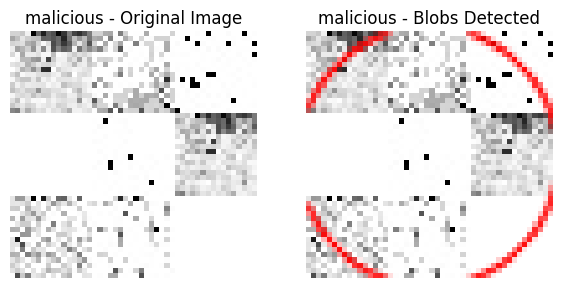

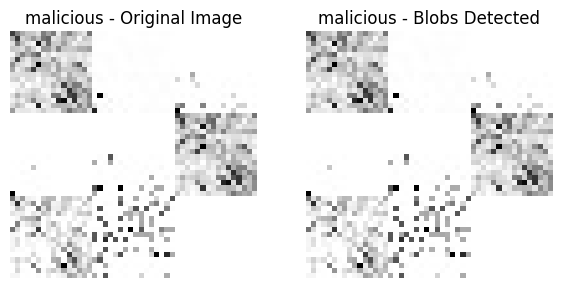

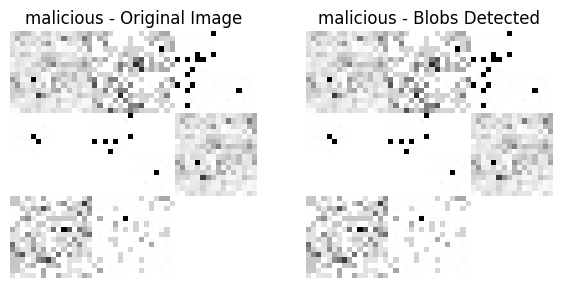

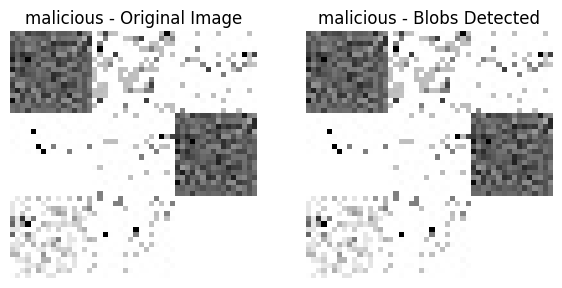

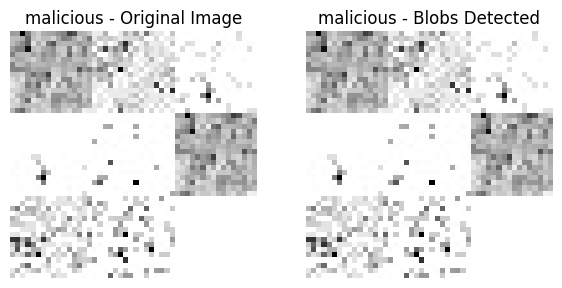

In [ ]:
# Function to detect and visualize defects in black and white images using blob detection
def detect_blobs_bw(df, num_images=5):
    """
    Detects and visualizes defects in images labeled as 'malicious' using blob detection.
    Displays the original image and the image with detected blobs side by side.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
                           Assumes columns 'Image_Path' and 'Label' exist in the DataFrame.
        num_images (int): Number of images to sample and analyze from the 'malicious' category (default: 5).
    """
    # Sample a few images from the 'malicious' category
    # Ensures that the number of samples does not exceed the number of available images in the category.
    df_malicious = df[df['Label'] == 'malicious'].sample(n=min(num_images, len(df[df['Label'] == 'malicious'])))

    # Internal function to process and display a single image with blob detection
    def process_image_bw(image_path, label):
        """
        Processes an image to detect blobs using the SimpleBlobDetector in OpenCV.

        Args:
            image_path (str): Path to the image file.
            label (str): Label indicating the category of the image ('malicious').
        """
        # Read the image from the specified path in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Error: Unable to read image at {image_path}")
            return

        # Set up the SimpleBlobDetector parameters
        params = cv2.SimpleBlobDetector_Params()

        # Filter by area (size of the blob)
        params.filterByArea = True
        params.minArea = 50  # Minimum area of the blob to be considered
        params.maxArea = 5000  # Maximum area of the blob to be considered

        # Filter by circularity (roundness of the blob)
        params.filterByCircularity = True
        params.minCircularity = 0.1  # Minimum circularity (0 is not circular, 1 is a perfect circle)

        # Filter by convexity (fullness of the blob)
        params.filterByConvexity = True
        params.minConvexity = 0.5  # Minimum convexity (0 is not convex, 1 is a perfect convex shape)

        # Filter by inertia (elongation of the blob)
        params.filterByInertia = True
        params.minInertiaRatio = 0.1  # Minimum inertia ratio (0 is very elongated, 1 is a perfect circle)

        # Create a blob detector with the defined parameters
        detector = cv2.SimpleBlobDetector_create(params)

        # Detect blobs in the grayscale image
        keypoints = detector.detect(img)

        # Draw detected blobs as red circles on the original image (converted to BGR for visualization)
        blob_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        blob_img = cv2.drawKeypoints(
            blob_img,
            keypoints,
            np.array([]),
            (0, 0, 255),  # Red color for the circles
            cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        # Display the original and blob-detected images side by side
        plt.figure(figsize=(7, 4))

        # Display the original image
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')  # Display in grayscale
        plt.title(f'{label} - Original Image')  # Title indicating the label and type of image
        plt.axis('off')  # Hide the axis for better visualization

        # Display the image with detected blobs
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(blob_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
        plt.title(f'{label} - Blobs Detected')  # Title indicating that blobs have been detected
        plt.axis('off')  # Hide the axis for better visualization

        # Show the figure with both images
        plt.show()

    # Analyze images from the 'malicious' category using the process_image function
    for _, row in df_malicious.iterrows():
        process_image_bw(row['Image_Path'], 'malicious')

# Perform defect detection using blob detection with 3 images from the 'malicious' category
detect_blobs_bw(df, num_images=3)


**CALCULATION OF MEAN AND STANDARD DEVIATION OF THE TRAINING SET FOR NORMALIZATION**

In [ ]:
# Define the directory path for the training dataset
train_dir = '/content/drive/MyDrive/Training_data'

# Function to compute the mean and standard deviation for grayscale images in a dataset
def calculate_mean_std_grayscale(dataset_dir):
    """
    Calculate the mean and standard deviation of grayscale pixel values in a dataset.

    Parameters:
    - dataset_dir (str): Directory path containing the image dataset.

    Returns:
    - mean_pixel (float): The mean grayscale pixel value.
    - std_pixel (float): The standard deviation of grayscale pixel values.
    """
    # Initialize accumulators for pixel values and count
    sum_pixel = 0.0
    sum_sq_pixel = 0.0
    num_pixels = 0

    # Traverse through the dataset directory
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            # Check if the file is an image (common formats)
            if file.endswith(('.png', '.jpg', '.jpeg')):
                # Load the image in grayscale using OpenCV
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)

                # Check if the image was loaded correctly
                if img is None:
                    print(f"Warning: Unable to read image {img_path}")
                    continue

                # Update pixel count, sum, and squared sum
                num_pixels += img.shape[0] * img.shape[1]
                sum_pixel += np.sum(img)
                sum_sq_pixel += np.sum(np.square(img))

    # Check if any images were processed
    if num_pixels == 0:
        print("Error: No images found in the dataset directory. Please check the path.")
        return None, None

    # Calculate mean and variance
    mean_pixel = sum_pixel / num_pixels
    var_pixel = (sum_sq_pixel / num_pixels) - (mean_pixel ** 2)
    var_pixel = max(var_pixel, 0)  # Ensure variance is non-negative

    # Calculate standard deviation
    std_pixel = np.sqrt(var_pixel)

    # Print the calculated mean and standard deviation for grayscale images
    print(f'Mean (Grayscale): {mean_pixel:.4f}')
    print(f'Std (Grayscale): {std_pixel:.4f}')

    return mean_pixel, std_pixel

# Calculate mean and standard deviation for the training dataset
mean, std = calculate_mean_std_grayscale(train_dir)

Mean (Grayscale): 236.0803
Std (Grayscale): 42.5024


**SPLITTING OF DATA**

In [ ]:
# Define constants for the number of clients, batch size, image size, and dataset paths
NUM_CLIENTS = 3
BATCH_SIZE = 32
IMAGE_SIZE = 224  # Image size for ResNet input

# Directory paths for training, validation, and test datasets
train_dir = '/content/drive/MyDrive/Training_data'
val_dir = '/content/drive/MyDrive/Validation_data'
test_dir = '/content/drive/MyDrive/Test_data'

# Mean and standard deviation of the grayscale dataset (calculated previously)
dataset_mean = 236.1568
dataset_std = 42.4124

# Define a custom transform to add Gaussian noise for data augmentation
class AddGaussianNoise(object):
    """Applies Gaussian noise to the input tensor."""
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# Function to load and split datasets into multiple clients with controlled imbalance
def load_datasets(train_dir, val_dir, test_dir, num_clients=NUM_CLIENTS, random_seed=42, max_imbalance=10):
    """
    Load datasets for training, validation, and testing.
    Split the training data among multiple clients with controlled class imbalance.

    Parameters:
    - train_dir (str): Directory path to the training data.
    - val_dir (str): Directory path to the validation data.
    - test_dir (str): Directory path to the test data.
    - num_clients (int): Number of clients to split the training data into.
    - random_seed (int): Seed for random number generators for reproducibility.
    - max_imbalance (int): Maximum allowed class imbalance between benign and malicious samples.

    Returns:
    - client_loaders (list): DataLoader objects for each client's training data.
    - val_loader (DataLoader): DataLoader for the validation data.
    - test_loader (DataLoader): DataLoader for the test data.
    - train_dataset (Dataset): The complete training dataset.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # Define transformation pipeline for training data (with data augmentation)
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        AddGaussianNoise(mean=0., std=0.1),
        transforms.Normalize(mean=[dataset_mean / 255.0], std=[dataset_std / 255.0]),
    ])

    # Load the complete training dataset with transformations applied
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

    # Get indices for benign and malicious samples
    benign_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == 0]
    malicious_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == 1]

    # Shuffle indices for randomness
    np.random.shuffle(benign_indices)
    np.random.shuffle(malicious_indices)

    # Calculate total samples and samples per client
    total_samples = len(benign_indices) + len(malicious_indices)
    total_samples_per_client = total_samples // num_clients

    # Initialize variables to keep track of data distribution and datasets for clients
    client_datasets = []
    client_data_info = defaultdict(list)
    benign_start_idx = 0
    malicious_start_idx = 0

    # Split the data among clients ensuring controlled class imbalance
    for i in range(num_clients):
        benign_per_client = total_samples_per_client // 2
        malicious_per_client = total_samples_per_client - benign_per_client

        # Adjust sample count for last client to include remaining samples
        if i == num_clients - 1:
            benign_per_client += len(benign_indices) - benign_end_idx
            malicious_per_client += len(malicious_indices) - malicious_end_idx

        # Maintain class balance within allowed imbalance range
        while abs(benign_per_client - malicious_per_client) > max_imbalance:
            if benign_per_client > malicious_per_client:
                benign_per_client -= 1
                malicious_per_client += 1
            else:
                benign_per_client += 1
                malicious_per_client -= 1

        # Determine the indices for the current client's dataset
        benign_end_idx = benign_start_idx + benign_per_client
        malicious_end_idx = malicious_start_idx + malicious_per_client
        client_indices = benign_indices[benign_start_idx:benign_end_idx] + malicious_indices[malicious_start_idx:malicious_end_idx]

        # Update starting indices for next client
        benign_start_idx = benign_end_idx
        malicious_start_idx = malicious_end_idx

        # Create a subset for the current client and append to the client datasets list
        client_dataset = Subset(train_dataset, client_indices)
        client_datasets.append(client_dataset)

        # Store class distribution for the current client
        class_counts = np.bincount([train_dataset.samples[idx][1] for idx in client_indices], minlength=2)
        client_data_info[f"Client {i+1}"] = dict(enumerate(class_counts))

        # Print the distribution and sample count for each client
        print(f"Client {i+1} Data Distribution: {client_data_info[f'Client {i+1}']}")
        print(f'Client {i+1} has {len(client_dataset)} samples.')

    # Print the total number of samples in the training dataset
    print(f'Total number of samples in the training set: {len(train_dataset)}')

    # Create DataLoaders for each client's dataset
    client_loaders = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in client_datasets]

    # Define transformation pipeline for validation and test data (without augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[dataset_mean / 255.0], std=[dataset_std / 255.0]),
    ])

    # Load validation and test datasets with transformation
    val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=val_transform)

    # Create DataLoaders for validation and test datasets
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Print validation set statistics
    print(f'Total number of samples in the validation set: {len(val_dataset)}')
    class_counts_val = {class_name: 0 for class_name in val_dataset.classes}
    for _, label in val_dataset.samples:
        class_name = val_dataset.classes[label]
        class_counts_val[class_name] += 1
    for class_name, count in class_counts_val.items():
        print(f'Number of samples in the {class_name} folder (Validation): {count}')

    # Print test set statistics
    print(f'Total number of samples in the test set: {len(test_dataset)}')
    class_counts_test = {class_name: 0 for class_name in test_dataset.classes}
    for _, label in test_dataset.samples:
        class_name = test_dataset.classes[label]
        class_counts_test[class_name] += 1
    for class_name, count in class_counts_test.items():
        print(f'Number of samples in the {class_name} folder (Test): {count}')

    return client_loaders, val_loader, test_loader, train_dataset

# Function to combine all client datasets into a single DataLoader for centralized training
def combined_train_loader(client_loaders):
    """
    Combine all client datasets into a single DataLoader.

    Parameters:
    - client_loaders (list): List of DataLoaders for each client's training data.

    Returns:
    - combined_loader (DataLoader): A DataLoader containing the combined dataset of all clients.
    """
    combined_dataset = ConcatDataset([ds.dataset for ds in client_loaders])
    combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return combined_loader

# Initialize datasets and create DataLoaders for clients, validation, and testing
client_loaders, val_loader, test_loader, train_dataset = load_datasets(train_dir, val_dir, test_dir)

# Combine all client loaders into a single DataLoader
combined_loader = combined_train_loader(client_loaders)

# Print the number of samples in the combined loader
print(f'The combined loader has {len(combined_loader.dataset)} samples.')

Client 1 Data Distribution: {0: 151, 1: 152}
Client 1 has 303 samples.
Client 2 Data Distribution: {0: 151, 1: 152}
Client 2 has 303 samples.
Client 3 Data Distribution: {0: 148, 1: 156}
Client 3 has 304 samples.
Total number of samples in the training set: 910
Total number of samples in the validation set: 130
Number of samples in the benign folder (Validation): 70
Number of samples in the malicious folder (Validation): 60
Total number of samples in the test set: 260
Number of samples in the benign folder (Test): 130
Number of samples in the malicious folder (Test): 130
The combined loader has 910 samples.


**DATA AUGMENTATIONS - RESIZING, ROTATION AND HORIZONTAL FLIP**

Displaying basic augmentations (Resize, Rotation, Horizontal Flip):


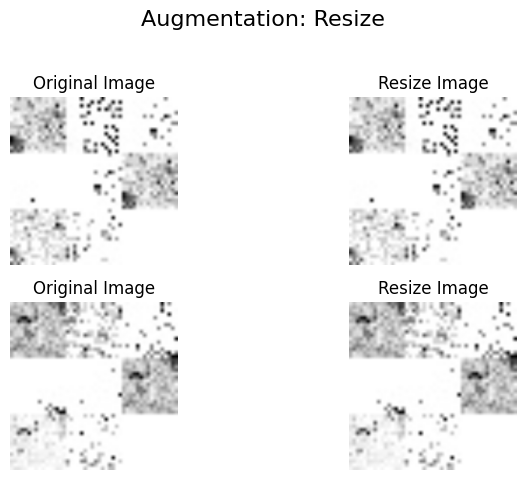

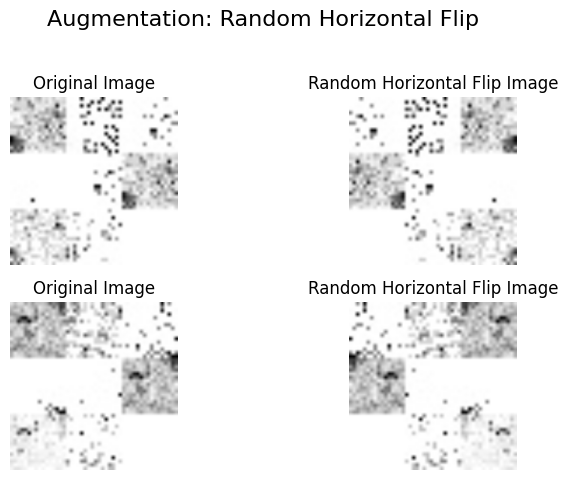

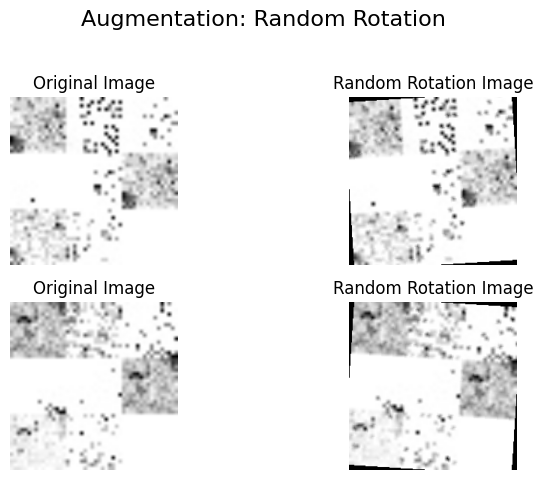

In [ ]:
# Function to display sample images for resizing, rotation, and horizontal flip
def display_basic_augmentations(train_dir):
    """
    Display two sample images for resizing, rotation, and horizontal flip augmentations.

    Args:
        train_dir (str): Directory path to the training data.
    """
    # Load the dataset without any transformations for displaying original images
    original_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
    dataset = datasets.ImageFolder(root=train_dir, transform=original_transform)

    # Randomly select two images from the dataset
    indices = random.sample(range(len(dataset)), 2)
    original_images = [dataset[i][0] for i in indices]

    # Convert tensors to PIL images for augmentation
    original_images_pil = [transforms.ToPILImage()(img) for img in original_images]

    # Define basic augmentation techniques
    augmentations = {
        "Resize": transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        "Random Horizontal Flip": transforms.RandomHorizontalFlip(p=1.0),
        "Random Rotation": transforms.RandomRotation(degrees=15),
    }

    # Display each augmentation technique
    for aug_name, aug_transform in augmentations.items():
        # Compose transformation with the augmentation
        transform_pipeline = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                 aug_transform,
                                                 transforms.ToTensor()])

        # Apply the augmentation to the selected images
        augmented_images = [transform_pipeline(img) for img in original_images_pil]

        # Display original and augmented images
        fig, axes = plt.subplots(2, 2, figsize=(8, 5))
        fig.suptitle(f'Augmentation: {aug_name}', fontsize=16)

        for i in range(2):
            # Display original image
            axes[i, 0].imshow(original_images[i].permute(1, 2, 0).numpy(), cmap='gray')
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            # Display augmented image
            augmented_image = augmented_images[i].numpy().transpose((1, 2, 0))
            axes[i, 1].imshow(augmented_image, cmap='gray')
            axes[i, 1].set_title(f'{aug_name} Image')
            axes[i, 1].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Display sample images for basic augmentations
print("Displaying basic augmentations (Resize, Rotation, Horizontal Flip):")
display_basic_augmentations(train_dir)



**ADDITION OF GAUSSIAN NOISE AND** **NORMALIZATION**


Displaying augmentations (Gaussian Noise, Normalization):


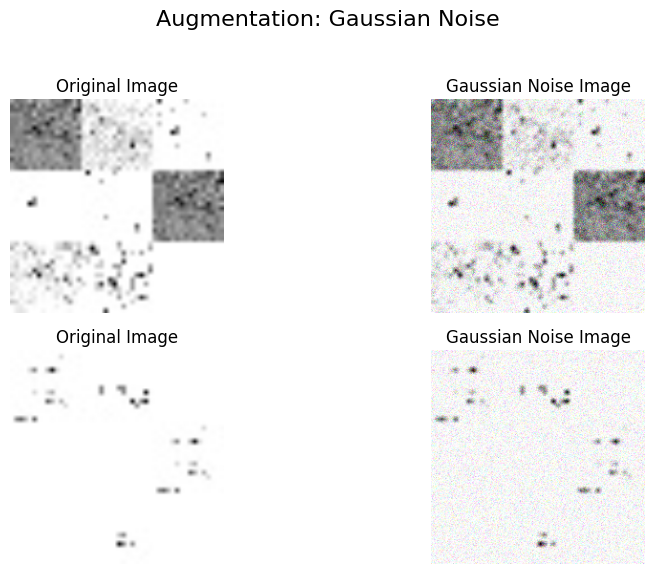

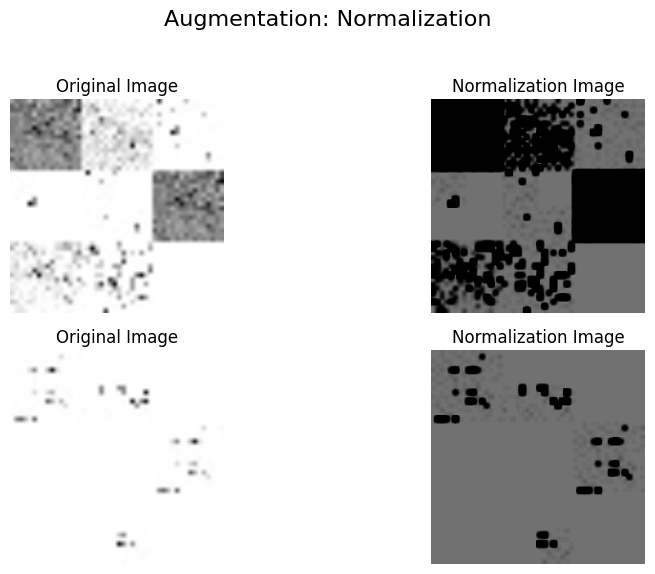

In [ ]:
# Define a custom transform to add Gaussian noise for data augmentation
class AddGaussianNoise(object):
    """Applies Gaussian noise to the input tensor."""
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        if not isinstance(tensor, torch.Tensor):
            raise TypeError("Input must be a torch.Tensor")
        noise = torch.randn(tensor.size(), device=tensor.device) * self.std + self.mean
        return torch.clamp(tensor + noise, 0, 1)  # Ensure values stay within [0, 1]

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

# Function to display sample images for Gau8omkpüssian noise and normalization
def display_noise_normalization(train_dir):
    """
    Display two sample images for Gaussian noise and normalization augmentations.

    Args:
        train_dir (str): Directory path to the training data.
    """
    # Load the dataset without any transformations for displaying original images
    original_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
    dataset = datasets.ImageFolder(root=train_dir, transform=original_transform)

    # Randomly select two images from the dataset
    indices = random.sample(range(len(dataset)), 2)
    original_images = [dataset[i][0] for i in indices]

    # Convert tensors to PIL images for augmentation
    original_images_pil = [transforms.ToPILImage()(img) for img in original_images]

    # Define noise and normalization augmentations
    augmentations = {
        "Gaussian Noise": AddGaussianNoise(mean=0., std=0.1),
        "Normalization": transforms.Compose([transforms.Normalize(mean=[dataset_mean / 255.0], std=[dataset_std / 255.0])]), # Remove ToTensor from here
    }

    # Display each augmentation technique
    for aug_name, aug_transform in augmentations.items():
        # Compose transformation with the augmentation
        # The ToTensor transform is moved before AddGaussianNoise
        transform_pipeline = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                 transforms.ToTensor(),  # Convert to tensor first
                                                 aug_transform])

        # Apply the augmentation to the selected images
        augmented_images = [transform_pipeline(img) for img in original_images_pil]

        # Display original and augmented images
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        fig.suptitle(f'Augmentation: {aug_name}', fontsize=16)

        for i in range(2):
            # Display original image
            axes[i, 0].imshow(original_images[i].permute(1, 2, 0).numpy(), cmap='gray')
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            # Display augmented image
            augmented_image = augmented_images[i].numpy().transpose((1, 2, 0))
            if aug_name == "Normalization":  # Normalize image for visualization purposes
                augmented_image = np.clip(augmented_image * 255, 0, 255).astype(np.uint8)
            axes[i, 1].imshow(augmented_image, cmap='gray')
            axes[i, 1].set_title(f'{aug_name} Image')
            axes[i, 1].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Display sample images for Gaussian noise and normalization
print("\nDisplaying augmentations (Gaussian Noise, Normalization):")
display_noise_normalization(train_dir)


**VISUALIZATION OF A SAMPLE OF IMAGES**

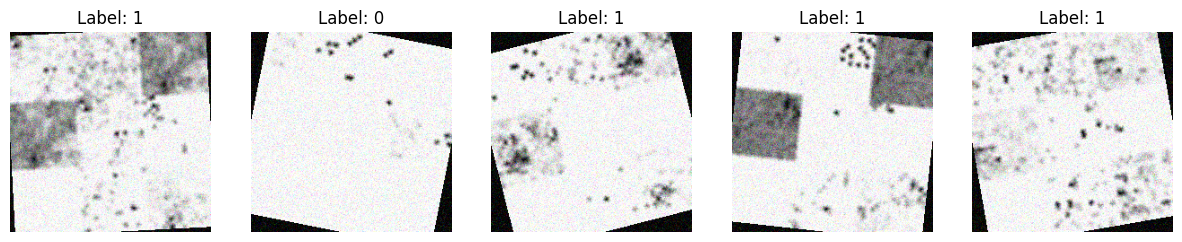

In [ ]:
# Function to denormalize an image tensor for visualization
def denormalize(tensor, mean, std):
    """
    Denormalizes the tensor by reversing the normalization applied during preprocessing.
    Converts the tensor values back to the [0, 1] range for proper display.

    Parameters:
    - tensor (Tensor): The image tensor to be denormalized.
    - mean (list): The mean value used for normalization.
    - std (list): The standard deviation value used for normalization.

    Returns:
    - tensor (Tensor): The denormalized image tensor.
    """
    mean = np.array(mean)
    std = np.array(std)

    # Iterate over the channels (for grayscale, only one channel) to denormalize
    for c in range(tensor.shape[0]):
        tensor[c] = tensor[c] * std[0] + mean[0]
    return tensor

# Function to display a sample of augmented images from the dataset
def show_augmented_images(dataset, num_images=5):
    """
    Displays a sample of augmented images from the dataset for visualization.

    Parameters:
    - dataset (Dataset): The dataset from which images are to be displayed.
    - num_images (int): The number of images to display. Default is 5.
    """
    # Create a DataLoader with a small batch size to load images for visualization
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)

    # Retrieve a batch of images and their corresponding labels
    images, labels = next(iter(loader))

    # Convert the images tensor to a numpy array and denormalize for display
    images = images.numpy()
    images = denormalize(images, mean=[dataset_mean / 255.0], std=[dataset_std / 255.0])

    # Set up a plot with subplots for each image
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        img = images[i]
        # Transpose the image from (channels, height, width) to (height, width, channels)
        img = np.transpose(img, (1, 2, 0))

        # Clip the image values to ensure they are within the [0, 1] range for display
        img = np.clip(img, 0, 1)

        # Display the image without grayscale colormap
        axs[i].imshow(img, cmap=None)
        axs[i].axis('off')
        axs[i].set_title(f"Label: {labels[i].item()}")

    # Show the plot with augmented images
    plt.show()

# Example usage: Display 5 augmented images from the training dataset
show_augmented_images(train_dataset, num_images=5)

**RESNET 18 MODEL**

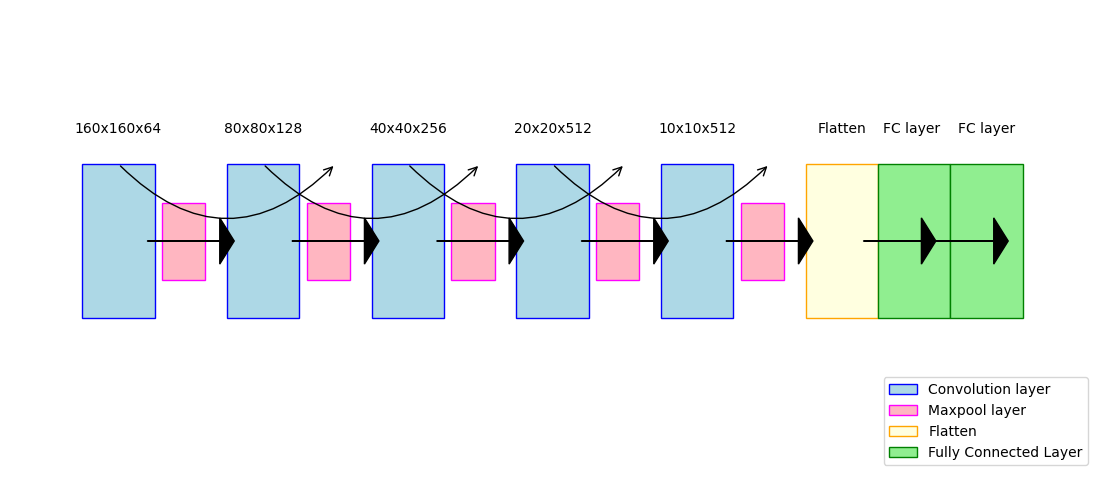

In [ ]:
# Define the ResNet18Model class based on the ResNet-18 architecture
class ResNet18Model(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        """
        Initializes the ResNet18Model for binary classification with custom modifications.

        Parameters:
        - num_classes (int): Number of output classes (default: 2).
        - dropout_rate (float): Dropout rate for regularization (default: 0.3).
        """
        super(ResNet18Model, self).__init__()

        # Load a pre-trained ResNet-18 model
        resnet18 = models.resnet18(pretrained=True)

        # Replace the final fully connected layer with a custom classifier
        resnet18.fc = nn.Sequential(
            nn.Dropout(0.3),  # Apply dropout for regularization
            nn.Linear(resnet18.fc.in_features, 2)  # Modify for binary classification
        )

        # Freeze all ResNet layers to prevent training
        for param in resnet18.parameters():
            param.requires_grad = False

        # Unfreeze the final two ResNet layers for fine-tuning
        for param in resnet18.layer4.parameters():
            param.requires_grad = True
        for param in resnet18.layer3.parameters():
            param.requires_grad = True

        # Extract features from the ResNet model up to the second last layer
        self.features = nn.Sequential(*list(resnet18.children())[:-2])

        # Define the custom classifier layers for this specific task
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Adaptive average pooling
            nn.Flatten()  # Flatten the output tensor
        )

        # Calculate the number of input features for the linear layer dynamically
        with torch.no_grad():
            self.num_ftrs = self._get_num_ftrs()

        # Add additional layers to the classifier
        self.classifier.add_module('linear1', nn.Linear(self.num_ftrs, 256))
        self.classifier.add_module('LeakyRelu', nn.LeakyReLU())
        self.classifier.add_module('dropout', nn.Dropout(dropout_rate))
        self.classifier.add_module('linear2', nn.Linear(256, num_classes))

    def _get_num_ftrs(self):
        """
        Calculate the number of input features required for the custom classifier.
        This is determined by running a forward pass with a sample input tensor.

        Returns:
        - int: The number of features for the linear layer.
        """
        test_input = torch.randn(1, 3, 224, 224)  # Sample input tensor
        features_output = self.features(test_input)
        classifier_input = self.classifier[:2](features_output)
        return classifier_input.view(-1).size(0)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Parameters:
        - x (Tensor): Input tensor representing a batch of images.

        Returns:
        - Tensor: Output tensor with class scores.
        """
        x = self.features(x)  # Extract features using ResNet
        x = self.classifier(x)  # Apply custom classifier
        return x

# Function to draw a block diagram illustrating the ResNet18 architecture with skip connections
def draw_block_diagram_with_skip_connections():
    """
    Creates a block diagram of the ResNet18 architecture, highlighting skip connections.
    Useful for visualizing the structure of the network with feature map dimensions.
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    # Define the labels and positions for the layers in the ResNet18 model
    layer_labels = ['160x160x64', '80x80x128', '40x40x256', '20x20x512', '10x10x512']
    layer_positions = [1, 3, 5, 7, 9]

    # Draw convolutional and max-pool layers side by side
    for pos, label in zip(layer_positions, layer_labels):
        ax.add_patch(Rectangle((pos, 3), 1, 1, edgecolor='blue', facecolor='lightblue'))  # Convolutional layer
        ax.text(pos + 0.5, 4.2, label, ha='center')
        ax.add_patch(Rectangle((pos + 1.1, 3.25), 0.6, 0.5, edgecolor='magenta', facecolor='lightpink'))  # Maxpool layer

    # Draw Flatten and Fully Connected (FC) layers for the classifier part
    ax.add_patch(Rectangle((11, 3), 1, 1, edgecolor='orange', facecolor='lightyellow'))  # Flatten
    ax.text(11.5, 4.2, 'Flatten', ha='center')
    ax.add_patch(Rectangle((12, 3), 1, 1, edgecolor='green', facecolor='lightgreen'))  # FC Layer 1
    ax.text(12.5, 4.2, 'FC layer', ha='center')
    ax.add_patch(Rectangle((13, 3), 1, 1, edgecolor='green', facecolor='lightgreen'))  # FC Layer 2
    ax.text(13.5, 4.2, 'FC layer', ha='center')

    # Add connections between layers
    for pos in layer_positions:
        ax.arrow(pos + 0.9, 3.5, 1, 0, head_width=0.3, head_length=0.2, fc='k', ec='k')
    for pos in [11, 12]:
        ax.arrow(pos + 0.8, 3.5, 0.8, 0, head_width=0.3, head_length=0.2, fc='k', ec='k')

    # Draw skip connections (ResNet feature) as curved arrows
    skip_positions = [(1, 3), (3, 5), (5, 7), (7, 9)]
    for start, end in skip_positions:
        ax.add_patch(FancyArrowPatch((start + 0.5, 4), (end + 1.5, 4), connectionstyle="arc3,rad=0.5",
                                     arrowstyle='->', mutation_scale=15, color='black'))

    # Set the axis limits and remove the axes for better visualization
    ax.set_xlim(0, 15)
    ax.set_ylim(2, 5)
    ax.axis('off')

    # Add a legend explaining each block type in the diagram
    legend_elements = [
        Rectangle((0, 0), 1, 1, edgecolor='blue', facecolor='lightblue', label='Convolution layer'),
        Rectangle((0, 0), 1, 1, edgecolor='magenta', facecolor='lightpink', label='Maxpool layer'),
        Rectangle((0, 0), 1, 1, edgecolor='orange', facecolor='lightyellow', label='Flatten'),
        Rectangle((0, 0), 1, 1, edgecolor='green', facecolor='lightgreen', label='Fully Connected Layer')
    ]
    ax.legend(handles=legend_elements, loc='lower right')

    # Display the plot with the block diagram
    plt.show()

# Instantiate the ResNet18Model to trigger the print statement
model = ResNet18Model()

# Draw the block diagram with skip connections to visualize the model architecture
draw_block_diagram_with_skip_connections()

**NON-FEDERATED LEARNING: MODEL TRAINING**

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


Epoch 1/5, Training Loss: 0.6108, Training Accuracy: 0.6638, Validation Loss: 0.6480, Validation Accuracy: 0.7462, Val Precision: 0.7213, Val Recall: 0.7333, Val F1: 0.7273, Val F2: 0.7309
Epoch 2/5, Training Loss: 0.5136, Training Accuracy: 0.7590, Validation Loss: 0.6336, Validation Accuracy: 0.5615, Val Precision: 0.5128, Val Recall: 1.0000, Val F1: 0.6780, Val F2: 0.8403
Epoch 3/5, Training Loss: 0.5038, Training Accuracy: 0.7543, Validation Loss: 0.6350, Validation Accuracy: 0.5231, Val Precision: 0.4918, Val Recall: 1.0000, Val F1: 0.6593, Val F2: 0.8287
Epoch 4/5, Training Loss: 0.5133, Training Accuracy: 0.7543, Validation Loss: 0.6336, Validation Accuracy: 0.5385, Val Precision: 0.5000, Val Recall: 1.0000, Val F1: 0.6667, Val F2: 0.8333
Epoch 5/5, Training Loss: 0.5184, Training Accuracy: 0.7533, Validation Loss: 0.6343, Validation Accuracy: 0.5385, Val Precision: 0.5000, Val Recall: 1.0000, Val F1: 0.6667, Val F2: 0.8333

Test Results:
Test Loss: 0.6687
Test Accuracy: 0.5333


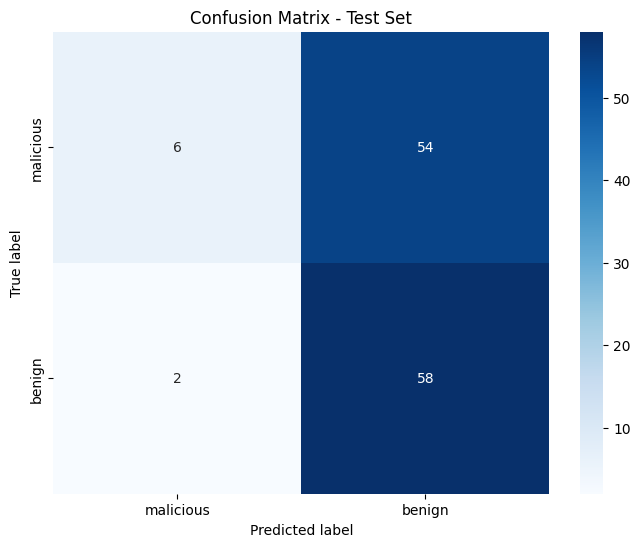

In [ ]:
# Select the device for training (GPU if available, otherwise CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ResNet18 model and move it to the selected device
net = ResNet18Model().to(DEVICE)

# Function for testing the model on the provided data loader
def test(net, loader, DEVICE, beta=2):
    """
    Evaluates the model performance on the test data.

    Parameters:
    - net (nn.Module): The trained model.
    - loader (DataLoader): DataLoader for test/validation data.
    - DEVICE (str): Device to run the evaluation on ('cuda' or 'cpu').
    - beta (int): Weight of recall in the F-beta score (default: 2).

    Returns:
    - loss (float): Average loss over the test data.
    - accuracy (float): Overall accuracy.
    - recall (float): Recall score.
    - precision (float): Precision score.
    - f1 (float): F1 score.
    - f2 (float): F2 score.
    - cm (ndarray): Confusion matrix.
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    all_preds = []
    all_labels = []
    net.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics
    loss /= len(loader)
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    f2 = fbeta_score(all_labels, all_preds, beta=beta, average='binary')
    cm = confusion_matrix(all_labels, all_preds)

    return loss, accuracy, recall, precision, f1, f2, cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.

    Parameters:
    - cm (ndarray): Confusion matrix values.
    - classes (list): List of class labels.
    - title (str): Title of the plot.
    - cmap (Colormap): Colormap for the matrix (default: plt.cm.Blues).
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Function to compute class weights based on training data distribution
def compute_class_weights(train_loader):
    """
    Computes class weights to handle class imbalance.

    Parameters:
    - train_loader (DataLoader): DataLoader for the training data.

    Returns:
    - class_weights (Tensor): Tensor containing weights for each class.
    """
    all_labels = []
    for _, labels in train_loader:
        all_labels.extend(labels.numpy())

    unique_classes = np.unique(all_labels)

    if len(unique_classes) == 1:
        # Only one class present, use uniform weights
        print(f"Only one class ({unique_classes[0]}) present in the dataset. Using uniform weights.")
        class_weights = [1.0, 1.0]  # Assign equal weights to both classes
    else:
        # Compute class weights normally based on distribution
        class_weights = compute_class_weight('balanced', classes=unique_classes, y=all_labels)

    return torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Function for training and evaluating the model
def train_and_evaluate(net, combined_loader=None, val_loader=None, test_loader=None, epochs: int = 3, DEVICE="cuda"):
    """
    Trains and evaluates the model with the provided data loaders.

    Parameters:
    - net (nn.Module): The model to train and evaluate.
    - combined_loader (DataLoader): Combined DataLoader for all clients.
    - val_loader (DataLoader): DataLoader for validation data.
    - test_loader (DataLoader): DataLoader for test data.
    - epochs (int): Number of training epochs (default: 3).
    - DEVICE (str): Device to run training on ('cuda' or 'cpu').

    Returns:
    - net (nn.Module): The trained model.
    - client_models (list): List of models for each client.
    """
    # Compute class weights for loss function
    class_weights = compute_class_weights(combined_loader)

    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 regularization
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # Learning rate scheduler

    client_models = []  # List to store client-specific models

    # Training process
    if combined_loader is not None:
        best_val_loss = float('inf')
        early_stopping_counter = 0
        patience = 5  # Early stopping patience

        for epoch in range(epochs):
            net.train()
            correct, total, epoch_loss = 0, 0, 0.0
            all_preds, all_labels = [], []

            for batch in combined_loader:
                images, labels = batch
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                optimizer.zero_grad()  # Clear gradients
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            scheduler.step()  # Update learning rate

            # Validation evaluation
            if val_loader is not None:
                val_loss, val_accuracy, val_recall, val_precision, val_f1, val_f2, _ = test(net, val_loader, DEVICE)

                # Print epoch results
                print(f"Epoch {epoch + 1}/{epochs}, "
                      f"Training Loss: {epoch_loss / len(combined_loader):.4f}, "
                      f"Training Accuracy: {correct / total:.4f}, "
                      f"Validation Loss: {val_loss:.4f}, "
                      f"Validation Accuracy: {val_accuracy:.4f}, "
                      f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, "
                      f"Val F1: {val_f1:.4f}, Val F2: {val_f2:.4f}")

                # Early stopping logic based on validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

                if early_stopping_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

    # Test evaluation
    if test_loader is not None:
        test_loss, test_accuracy, test_recall, test_precision, test_f1, test_f2, test_cm = test(net, test_loader, DEVICE)
        print("\nTest Results:")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")
        print(f"Test F2 Score: {test_f2:.4f}")
        class_names = ['malicious', 'benign']  # Modify according to your dataset classes
        plot_confusion_matrix(test_cm, class_names, title='Confusion Matrix - Test Set')

    return net, client_models

# Train the model with the provided data loaders and number of epochs
epochs = 5  # Set the number of epochs for training
trained_net, client_models = train_and_evaluate(net, combined_loader, val_loader, test_loader, epochs, DEVICE)

**CORRECTED CONFUSION MATRIX** (by swapping rows and columns)

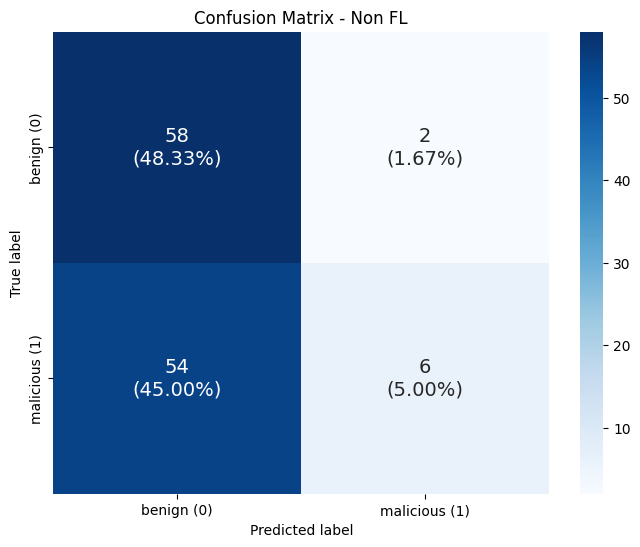

True Positives (TP): 6
False Positives (FP): 2
True Negatives (TN): 58
False Negatives (FN): 54
Accuracy: 0.5333
Precision: 0.7500
Recall: 0.1000
F1 Score: 0.1765
F2 Score: 0.1210


In [ ]:
def process_and_plot_confusion_matrix(test_cm, title="Confusion Matrix"):
    # Swap rows and columns to make 'Benign (0)' first and 'Malicious (1)' second
    corrected_cm = test_cm[[1, 0], :]  # Swap rows (True Labels)
    corrected_cm = corrected_cm[:, [1, 0]]  # Swap columns (Predicted Labels)

    # Define consistent class labels
    class_labels = ['benign (0)', 'malicious (1)']  # Benign first, Malicious second

    # Calculate relative distribution
    total = np.sum(corrected_cm)  # Total number of samples
    relative_cm = (corrected_cm / total) * 100  # Relative percentages

    # Plot the corrected confusion matrix with both values and percentages
    def plot_matrix(cm, relative_cm, class_labels, title):
        plt.figure(figsize=(8, 6))
        # Create a combined annotation (raw values + percentages)
        combined_annot = np.array([[f"{int(cm[i, j])}\n({relative_cm[i, j]:.2f}%)"
                                    for j in range(cm.shape[1])] for i in range(cm.shape[0])])

        sns.heatmap(cm, annot=combined_annot, fmt='', cmap=plt.cm.Blues,
                    xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
        plt.title(title)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    plot_matrix(corrected_cm, relative_cm, class_labels, title)

    # Extract TP, FP, FN, TN based on the new order
    TN = corrected_cm[0, 0]  # True Benign predicted as Benign
    FN = corrected_cm[1, 0]  # True Malicious predicted as Benign
    FP = corrected_cm[0, 1]  # True Benign predicted as Malicious
    TP = corrected_cm[1, 1]  # True Malicious predicted as Malicious

    # Recalculate metrics
    accuracy = (TP + TN) / total
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    f2 = (1 + 2**2) * (precision * recall) / ((4 * precision) + recall) if (precision + recall) != 0 else 0

    # Print the results
    # print(f"Metrics for {title}:")
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")

# Confusion Matrix
test_cm_1 = np.array([[6, 54],  # True: Malicious (1)
                      [2, 58]]) # True: Benign (0)
process_and_plot_confusion_matrix(test_cm_1, "Confusion Matrix - Non FL")

**FEDERATED LEARNING**

**FUNCTION TO SET AND GET THE PARAMETERS OF THE MODEL**

In [ ]:
# Function to set the parameters of the neural network model
def set_parameters(net, parameters: List[np.ndarray]):
    """
    Load parameters into the provided network model.

    This function is typically used in a federated learning context where model parameters
    received from a server or aggregated from multiple clients are loaded into a local model
    instance on a client or during aggregation on the server.

    Args:
        net (torch.nn.Module): The neural network model whose parameters are to be set.
        parameters (List[np.ndarray]): A list of NumPy arrays containing the model parameters.
                                       These parameters are typically aggregated and sent by the server.

    Returns:
        None
    """
    # Create a dictionary that pairs the model's parameter names with the provided parameter values.
    # `net.state_dict().keys()` provides the keys (parameter names) for the current model,
    # while `parameters` contains the new parameter values (from federated learning).
    params_dict = zip(net.state_dict().keys(), parameters)

    # Create a new OrderedDict where each key (parameter name) is associated with a tensor
    # converted from the corresponding NumPy array in the provided parameters list.
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})

    # Load the new state_dict into the model. `strict=True` ensures that the keys of the
    # state_dict and the input match exactly, raising an error if they do not.
    net.load_state_dict(state_dict, strict=True)


# Function to get the parameters from the neural network model
def get_parameters(net) -> List[np.ndarray]:
    """
    Retrieve the parameters of the provided network model.

    This function is typically used in federated learning to extract the model parameters
    from a client's local model instance. These parameters can then be sent to a server
    for aggregation with parameters from other clients or for evaluation.

    Args:
        net (torch.nn.Module): The neural network model from which parameters are to be retrieved.

    Returns:
        List[np.ndarray]: A list of the model's parameters as NumPy arrays, which allows for
                          easier manipulation and transmission over networks.
    """
    # Extract each parameter tensor from the model's state_dict.
    # Convert each tensor to CPU (to ensure compatibility even if the model is on a GPU),
    # and then convert the tensor to a NumPy array for easier manipulation and transmission.
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

**FLOWER CLIENT CLASS**

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    """
    Custom client class for federated learning using the Flower framework.

    This class implements methods to manage a PyTorch model's lifecycle within a federated
    learning session, including setting parameters received from the server, training the model,
    and evaluating its performance.

    Attributes:
        net (torch.nn.Module): The PyTorch model to train and evaluate.
        client_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
    """

    # Constructor
    def __init__(self, net, client_loader, val_loader):
        """
        Initializes the FlowerClient instance with a network, training dataloader, and validation dataloader.

        Args:
            net (torch.nn.Module): The neural network model to train and evaluate.
            client_loader (DataLoader): DataLoader for the training dataset.
            val_loader (DataLoader): DataLoader for the validation dataset.
        """
        self.net = net
        self.client_loader = client_loader
        self.val_loader = val_loader
        self.local_model = None  # Placeholder to store local model state

    # Method to retrieve the current model parameters
    def get_parameters(self, config):
        """
        Retrieves the current model parameters.

        This method is called by the Flower server to get the current weights from this client's model.

        Args:
            config (dict): Configuration parameters supplied by the Flower server, can be used to
                           customize parameter retrieval if needed.

        Returns:
            List[np.ndarray]: The current model parameters as a list of NumPy arrays.
        """
        return get_parameters(self.net)

    # Method to train the model using provided parameters and local training data
    def fit(self, parameters, config):
        """
        Trains the model using the provided parameters and the local training data.

        This method sets the provided parameters to the model, performs training, and returns the updated parameters.

        Args:
            parameters (List[np.ndarray]): Parameters to be loaded into the model.
            config (dict): Configuration parameters supplied by the Flower server

        Returns:
            tuple: A tuple containing the updated model parameters, the number of examples used for training,
                   and an empty dictionary (can be used to return additional training metadata).
        """
        # Load the global model parameters into the local model
        set_parameters(self.net, parameters)

        # Train the model on the local dataset
        train_and_evaluate(self.net, self.client_loader, self.val_loader, test_loader=None, epochs=5, DEVICE=DEVICE)

        # Store the local model's state after training
        self.local_model = self.net.state_dict()

        # Return the updated model parameters, the number of training examples, and an empty dictionary
        return get_parameters(self.net), len(self.client_loader.dataset), {}

    # Method to evaluate the model on the local validation dataset
    def evaluate(self, parameters, config):
        """
        Evaluates the model on the local validation dataset.

        This method sets the provided parameters to the model and evaluates its performance.

        Args:
            parameters (List[np.ndarray]): Parameters to be loaded into the model.
            config (dict): Configuration parameters supplied by the Flower server

        Returns:
            tuple: A tuple containing the evaluation loss, the number of examples used for evaluation,
                   and a dictionary containing various performance metrics such as accuracy, recall,
                   precision, F1, and F2 scores.
        """
        # Load the global parameters into the local model
        set_parameters(self.net, parameters)

        # Evaluate the model on the local validation dataset
        loss, accuracy, recall, precision, f1, f2, cm = test(self.net, self.val_loader, DEVICE)

        # Print metrics at the client level
        print(f"\nClient Validation Results:")   # Print client-level metrics
        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation Precision: {precision:.4f}")
        print(f"Validation Recall: {recall:.4f}")
        print(f"Validation F1 Score: {f1:.4f}")
        print(f"Validation F2 Score: {f2:.4f}")

        # Return evaluation loss, number of examples, and a dictionary of metrics
        return float(loss), len(self.val_loader.dataset), {
            "accuracy": float(accuracy),
            "recall": float(recall),
            "precision": float(precision),
            "f1": float(f1),
            "f2": float(f2)
        }

    # Method to retrieve the local model state dictionary
    def get_local_model(self):
        """
        Retrieves the local model state dictionary.

        This method is useful for debugging or saving the local model's state after training.

        Returns:
            state_dict (OrderedDict): The local model's state dictionary.
        """
        return self.local_model

**FLOWER CLIENT FUNCTION**

In [ ]:
# List to store instances of FlowerClient for each client
clients_list = []

def client_fn(cid: str) -> FlowerClient:
    """
    Function to initialize a FlowerClient instance representing an individual federated learning client.

    Args:
        cid (str): A unique client ID assigned by the Flower server during federated learning.
                   It is provided as a string but converted to an integer for indexing.

    Returns:
        FlowerClient: An initialized FlowerClient object ready to participate in federated learning.
    """
    # Convert the client ID to an integer to use as an index for DataLoader selection.
    client_id = int(cid)

    # Initialize the ResNet18 model and move it to the appropriate device (GPU or CPU).
    net = ResNet18Model().to(DEVICE)

    # Retrieve the specific DataLoader for training using the client_id.
    # client_loaders is assumed to be a pre-defined list containing DataLoader objects for each client.
    trainloader = client_loaders[client_id]

    # Use a shared validation loader for all clients, assuming val_loader is defined.
    valloader = val_loader

    # Instantiate a FlowerClient with the initialized model and the selected DataLoaders.
    client = FlowerClient(net, trainloader, valloader)

    # Store the client instance in the clients_list for future reference or debugging.
    clients_list.append(client)

    # Return the instantiated FlowerClient to the federated learning framework.
    return client

**CLIENT RESOURCES**

In [ ]:
# Define the default client resources as one CPU and no GPU.
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Check if the current device is CUDA-enabled (GPU available).
if DEVICE.type == "cuda":
    # If CUDA is available, allocate one GPU per client.
    client_resources["num_gpus"] = 1.0

# Print out the resource allocation for verification.
print(f"Client resources allocated: {client_resources}")

**WEIGHTED AVERAGE FUNCTION**

In [ ]:
def weighted_average(metrics):
    """
    Aggregates metrics from multiple clients using a weighted average where the weight
    is the number of examples that each client contributes.

    This function is typically used in federated learning to compute a global evaluation metric
    that reflects the performance across all participating clients, factoring in the
    size of the dataset each client holds.

    Args:
        metrics (list of tuples): A list where each tuple contains the number of examples
                                  from a client and a dictionary of metrics reported by that client.
                                  Format: [(num_examples_client1, metrics_client1), ...]

    Returns:
        dict: A dictionary containing the aggregated metrics, including accuracy, recall,
              precision, F1, and F2 scores.
    """
    # Calculate the total number of examples contributed by all clients
    total_examples = sum(num_examples for num_examples, _ in metrics)

    # Lambda function to calculate the weighted sum of a specific metric across all clients.
    # For each metric, multiply the client's metric value by the number of examples the client contributes.
    weighted_sum = lambda metric: sum(num_examples * m[metric] for num_examples, m in metrics if metric in m)

    # Calculate the weighted average for each key metric and store it in a dictionary.
    aggregated_metrics = {
        "accuracy": weighted_sum("accuracy") / total_examples,
        "recall": weighted_sum("recall") / total_examples,
        "precision": weighted_sum("precision") / total_examples,
        "f1": weighted_sum("f1") / total_examples,
        "f2": weighted_sum("f2") / total_examples,
    }

    return aggregated_metrics

In [ ]:
# Initialize the ResNet18 model and move it to the selected device (CPU/GPU).
# This model will act as the global model in the federated learning setup.
global_model = ResNet18Model().to(DEVICE)

# Print confirmation of the model initialization and its device placement
print(f"Global model initialized on device: {DEVICE}")

**DATA PROCESSING**

In [ ]:
# Define transformations for the validation and test datasets
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to match the model's expected input size
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize(mean=[dataset_mean / 255.0], std=[dataset_std / 255.0]),  # Normalize using dataset statistics
])

# Load the test dataset with the specified transformations
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Function to evaluate the global model on the global test set
def evaluate_global_model(global_model, global_test_loader):
    """
    Evaluates the global model on a global test set.

    This function uses the test loader to calculate and print various evaluation metrics,
    such as loss, accuracy, precision, recall, F1 score, and the confusion matrix.

    Args:
        global_model (torch.nn.Module): The final global model after federated training.
        global_test_loader (DataLoader): The DataLoader for the global test set.

    Returns:
        dict: A dictionary containing evaluation metrics including loss, accuracy,
              precision, recall, F1 score, F2 score, and the confusion matrix.
    """
    global_model.eval()  # Set the model to evaluation mode
    # Evaluate the model on the global test set using the previously defined `test` function
    loss, accuracy, recall, precision, f1, f2, cm = test(global_model, global_test_loader, DEVICE)

    # Print the evaluation metrics
    print(f"\nGlobal Test Results:")
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test F2 Score: {f2:.4f}")

    # Define class names based on the dataset's classes
    class_names = ['malicious', 'benign']

    # Plot the confusion matrix to visualize model performance across different classes
    plot_confusion_matrix(cm, class_names, title='Confusion Matrix - Global Test Set')

    # Return a dictionary of the evaluation metrics
    return {
        "loss": loss,
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "f2": f2,
        "confusion_matrix": cm
    }

# Create a DataLoader for the global test set with the same test_dataset used above
global_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

**FEDAVG STRATEGY**

**MODEL TRAINING AND EVALUATION**

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-09-21 18:44:27,191	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 32654037812.0, 'object_store_memory': 16327018905.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=26106) 2024-09-21 18:44:30.305911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=26106) 2024-09-21 18:44:30.346159: E external/local_xla/xla/st

(ClientAppActor pid=26107) Epoch 1/5, Training Loss: 0.6654, Training Accuracy: 0.6000, Validation Loss: 0.7028, Validation Accuracy: 0.5462, Val Precision: 1.0000, Val Recall: 0.0167, Val F1: 0.0328, Val F2: 0.0207


(ClientAppActor pid=26106) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26106)   _warn_prf(average, modifier, msg_start, len(result))
(ClientAppActor pid=26105) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=26105)          [repeated 2x across cluster]
(ClientAppActor pid=26105)             This is a deprecated feature. It will be removed
(ClientAppActor pid=26105)             entirely in future versions of Flower.
(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is depr

(ClientAppActor pid=26107) Epoch 2/5, Training Loss: 0.6291, Training Accuracy: 0.6086, Validation Loss: 0.6888, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000 [repeated 3x across cluster]


(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior. [repeated 2x across cluster]
(ClientAppActor pid=26107)   _warn_prf(average, modifier, msg_start, len(result)) [repeated 2x across cluster]


(ClientAppActor pid=26106) Epoch 2/5, Training Loss: 0.6552, Training Accuracy: 0.5971, Validation Loss: 0.7057, Validation Accuracy: 0.5385, Val Precision: 0.5000, Val Recall: 0.0167, Val F1: 0.0323, Val F2: 0.0207


(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26105)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26105) Epoch 2/5, Training Loss: 0.6411, Training Accuracy: 0.6571, Validation Loss: 0.7036, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000
(ClientAppActor pid=26107) Epoch 3/5, Training Loss: 0.6311, Training Accuracy: 0.6571, Validation Loss: 0.6777, Validation Accuracy: 0.5385, Val Precision: 0.5000, Val Recall: 0.0167, Val F1: 0.0323, Val F2: 0.0207
(ClientAppActor pid=26106) Epoch 3/5, Training Loss: 0.6298, Training Accuracy: 0.6429, Validation Loss: 0.7041, Validation Accuracy: 0.5538, Val Precision: 0.6250, Val Recall: 0.0833, Val F1: 0.1471, Val F2: 0.1008


(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26105)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26107) Epoch 4/5, Training Loss: 0.6128, Training Accuracy: 0.6657, Validation Loss: 0.6764, Validation Accuracy: 0.5846, Val Precision: 0.8000, Val Recall: 0.1333, Val F1: 0.2286, Val F2: 0.1600 [repeated 2x across cluster]


(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26105)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26107) Epoch 5/5, Training Loss: 0.6173, Training Accuracy: 0.6429, Validation Loss: 0.6763, Validation Accuracy: 0.5692, Val Precision: 0.6429, Val Recall: 0.1500, Val F1: 0.2432, Val F2: 0.1772 [repeated 3x across cluster]


(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26105)   _warn_prf(average, modifier, msg_start, len(result))
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26106) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=26106) 
(ClientAppActor pid=26106)             This is a deprecated feature. It will be removed
(ClientAppActor pid=26106)             entirely in future versions of Flower.
(ClientAppActor pid=26106)         
(ClientAppActor pi

(ClientAppActor pid=26106) 
(ClientAppActor pid=26106) Client Validation Results:
(ClientAppActor pid=26106) Validation Loss: 0.6914
(ClientAppActor pid=26106) Validation Accuracy: 0.5615
(ClientAppActor pid=26106) Validation Precision: 0.7143
(ClientAppActor pid=26106) Validation Recall: 0.0833
(ClientAppActor pid=26106) Validation F1 Score: 0.1493
(ClientAppActor pid=26106) Validation F2 Score: 0.1012
(ClientAppActor pid=26106) Epoch 5/5, Training Loss: 0.6262, Training Accuracy: 0.6600, Validation Loss: 0.6993, Validation Accuracy: 0.5538, Val Precision: 0.5625, Val Recall: 0.1500, Val F1: 0.2368, Val F2: 0.1758 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26107) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=26107)          [repeated 6x across cluster]
(ClientAppActor pid=26107)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=26107)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 

(ClientAppActor pid=26107)  [repeated 2x across cluster]
(ClientAppActor pid=26107) Client Validation Results: [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Loss: 0.6914 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Accuracy: 0.5615 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Precision: 0.7143 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Recall: 0.0833 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation F2 Score: 0.1012 [repeated 4x across cluster]
(ClientAppActor pid=26106) Epoch 1/5, Training Loss: 0.6155, Training Accuracy: 0.6743, Validation Loss: 0.7021, Validation Accuracy: 0.5462, Val Precision: 1.0000, Val Recall: 0.0167, Val F1: 0.0328, Val F2: 0.0207
(ClientAppActor pid=26107) Epoch 1/5, Training Loss: 0.6165, Training Accuracy: 0.6571, Validation Loss: 0.7296, Validation Accuracy: 0.5462, Val Precision: 1.0000, Val Recall: 0.0167, Val F1: 0.0328, Val F2: 0.0207


(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26105)   _warn_prf(average, modifier, msg_start, len(result))
(ClientAppActor pid=26106) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=26106)          [repeated 4x across cluster]
(ClientAppActor pid=26106)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=26106)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=26106) /usr/local/lib/python3.10/dist-pac

(ClientAppActor pid=26105) Epoch 2/5, Training Loss: 0.6007, Training Accuracy: 0.6429, Validation Loss: 0.7250, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000 [repeated 2x across cluster]
(ClientAppActor pid=26106) Epoch 3/5, Training Loss: 0.5553, Training Accuracy: 0.7200, Validation Loss: 0.6799, Validation Accuracy: 0.6154, Val Precision: 0.7273, Val Recall: 0.2667, Val F1: 0.3902, Val F2: 0.3053 [repeated 3x across cluster]


(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26105)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26106) Epoch 4/5, Training Loss: 0.5749, Training Accuracy: 0.6886, Validation Loss: 0.6824, Validation Accuracy: 0.6231, Val Precision: 0.7391, Val Recall: 0.2833, Val F1: 0.4096, Val F2: 0.3232 [repeated 3x across cluster]


(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26105)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26106) Epoch 5/5, Training Loss: 0.5383, Training Accuracy: 0.7371, Validation Loss: 0.6782, Validation Accuracy: 0.6154, Val Precision: 0.6471, Val Recall: 0.3667, Val F1: 0.4681, Val F2: 0.4015 [repeated 3x across cluster]


(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26105)   _warn_prf(average, modifier, msg_start, len(result))
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26107) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=26107) 
(ClientAppActor pid=26107)             This is a deprecated feature. It will be removed
(ClientAppActor pid=26107)             entirely in future versions of Flower.
(ClientAppActor pid=26107)         
(ClientAppActor pi

(ClientAppActor pid=26105) 
(ClientAppActor pid=26105) Client Validation Results:
(ClientAppActor pid=26105) Validation Loss: 0.6944
(ClientAppActor pid=26105) Validation Accuracy: 0.5923
(ClientAppActor pid=26105) Validation Precision: 0.7059
(ClientAppActor pid=26105) Validation Recall: 0.2000
(ClientAppActor pid=26105) Validation F1 Score: 0.3117
(ClientAppActor pid=26105) Validation F2 Score: 0.2335
(ClientAppActor pid=26107) Epoch 5/5, Training Loss: 0.5516, Training Accuracy: 0.7143, Validation Loss: 0.6911, Validation Accuracy: 0.6077, Val Precision: 0.6800, Val Recall: 0.2833, Val F1: 0.4000, Val F2: 0.3208 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26107) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=26107)          [repeated 6x across cluster]
(ClientAppActor pid=26107)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=26107)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 

(ClientAppActor pid=26107)  [repeated 2x across cluster]
(ClientAppActor pid=26107) Client Validation Results: [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Loss: 0.6944 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Accuracy: 0.5923 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Precision: 0.7059 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Recall: 0.2000 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation F2 Score: 0.2335 [repeated 4x across cluster]
(ClientAppActor pid=26106) Epoch 1/5, Training Loss: 0.5582, Training Accuracy: 0.7286, Validation Loss: 0.7115, Validation Accuracy: 0.5923, Val Precision: 0.7333, Val Recall: 0.1833, Val F1: 0.2933, Val F2: 0.2157
(ClientAppActor pid=26107) Epoch 1/5, Training Loss: 0.5695, Training Accuracy: 0.7371, Validation Loss: 0.8482, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000


(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26107)   _warn_prf(average, modifier, msg_start, len(result))
(ClientAppActor pid=26105) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=26105)          [repeated 4x across cluster]
(ClientAppActor pid=26105)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=26105)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-pac

(ClientAppActor pid=26106) Epoch 2/5, Training Loss: 0.5039, Training Accuracy: 0.7714, Validation Loss: 0.6992, Validation Accuracy: 0.6077, Val Precision: 0.7368, Val Recall: 0.2333, Val F1: 0.3544, Val F2: 0.2703 [repeated 2x across cluster]


(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26107)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26106) Epoch 3/5, Training Loss: 0.4926, Training Accuracy: 0.7657, Validation Loss: 0.6866, Validation Accuracy: 0.5923, Val Precision: 0.6207, Val Recall: 0.3000, Val F1: 0.4045, Val F2: 0.3346 [repeated 3x across cluster]


(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26107)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26106) Epoch 4/5, Training Loss: 0.5075, Training Accuracy: 0.7571, Validation Loss: 0.6786, Validation Accuracy: 0.6154, Val Precision: 0.6562, Val Recall: 0.3500, Val F1: 0.4565, Val F2: 0.3860 [repeated 3x across cluster]


(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26107)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26106) Epoch 5/5, Training Loss: 0.5067, Training Accuracy: 0.7914, Validation Loss: 0.6841, Validation Accuracy: 0.5923, Val Precision: 0.6207, Val Recall: 0.3000, Val F1: 0.4045, Val F2: 0.3346 [repeated 3x across cluster]


(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26107)   _warn_prf(average, modifier, msg_start, len(result))
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26107) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=26107) 
(ClientAppActor pid=26107)             This is a deprecated feature. It will be removed
(ClientAppActor pid=26107)             entirely in future versions of Flower.
(ClientAppActor pid=26107)         
(ClientAppActor pi

(ClientAppActor pid=26105) 
(ClientAppActor pid=26105) Client Validation Results:
(ClientAppActor pid=26105) Validation Loss: 0.7119
(ClientAppActor pid=26105) Validation Accuracy: 0.5769
(ClientAppActor pid=26105) Validation Precision: 0.8571
(ClientAppActor pid=26105) Validation Recall: 0.1000
(ClientAppActor pid=26105) Validation F1 Score: 0.1791
(ClientAppActor pid=26105) Validation F2 Score: 0.1215
(ClientAppActor pid=26107) Epoch 5/5, Training Loss: 0.4957, Training Accuracy: 0.7857, Validation Loss: 0.7643, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26107) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=26107)          [repeated 6x across cluster]
(ClientAppActor pid=26107)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=26107)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 

(ClientAppActor pid=26107)  [repeated 2x across cluster]
(ClientAppActor pid=26107) Client Validation Results: [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Loss: 0.7119 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Accuracy: 0.5769 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Precision: 0.8571 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Recall: 0.1000 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation F2 Score: 0.1215 [repeated 4x across cluster]
(ClientAppActor pid=26107) Epoch 1/5, Training Loss: 0.4889, Training Accuracy: 0.7629, Validation Loss: 0.7090, Validation Accuracy: 0.6154, Val Precision: 0.8125, Val Recall: 0.2167, Val F1: 0.3421, Val F2: 0.2539


(ClientAppActor pid=26106) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26106)   _warn_prf(average, modifier, msg_start, len(result))
(ClientAppActor pid=26105) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=26105)          [repeated 4x across cluster]
(ClientAppActor pid=26105)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=26105)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-pac

(ClientAppActor pid=26106) Epoch 1/5, Training Loss: 0.5324, Training Accuracy: 0.7743, Validation Loss: 0.9416, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000
(ClientAppActor pid=26107) Epoch 2/5, Training Loss: 0.4741, Training Accuracy: 0.8057, Validation Loss: 0.6828, Validation Accuracy: 0.6000, Val Precision: 0.6429, Val Recall: 0.3000, Val F1: 0.4091, Val F2: 0.3358 [repeated 2x across cluster]


(ClientAppActor pid=26106) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26106)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26107) Epoch 3/5, Training Loss: 0.4602, Training Accuracy: 0.7829, Validation Loss: 0.6711, Validation Accuracy: 0.6385, Val Precision: 0.6667, Val Recall: 0.4333, Val F1: 0.5253, Val F2: 0.4659 [repeated 3x across cluster]


(ClientAppActor pid=26106) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26106)   _warn_prf(average, modifier, msg_start, len(result))
(ClientAppActor pid=26106) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26106)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26106) Epoch 4/5, Training Loss: 0.4869, Training Accuracy: 0.7743, Validation Loss: 0.8250, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000 [repeated 3x across cluster]


(ClientAppActor pid=26106) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=26106)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=26106) Epoch 5/5, Training Loss: 0.5350, Training Accuracy: 0.7400, Validation Loss: 0.8380, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26105) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=26105) 
(ClientAppActor pid=26105)             This is a deprecated feature. It will be removed
(ClientAppActor pid=26105)             entirely in future versions of Flower.
(ClientAppActor pid=26105)         
(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=26105)   warnings.warn(
(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/torchvision/models/_ut

(ClientAppActor pid=26105) 
(ClientAppActor pid=26105) Client Validation Results:
(ClientAppActor pid=26105) Validation Loss: 0.6989
(ClientAppActor pid=26105) Validation Accuracy: 0.6077
(ClientAppActor pid=26105) Validation Precision: 0.7368
(ClientAppActor pid=26105) Validation Recall: 0.2333
(ClientAppActor pid=26105) Validation F1 Score: 0.3544
(ClientAppActor pid=26105) Validation F2 Score: 0.2703
(ClientAppActor pid=26105) Epoch 5/5, Training Loss: 0.4739, Training Accuracy: 0.8000, Validation Loss: 0.6576, Validation Accuracy: 0.6615, Val Precision: 0.6538, Val Recall: 0.5667, Val F1: 0.6071, Val F2: 0.5822 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26107) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=26107)          [repeated 6x across cluster]
(ClientAppActor pid=26107)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=26107)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=26107) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 

(ClientAppActor pid=26107)  [repeated 2x across cluster]
(ClientAppActor pid=26107) Client Validation Results: [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Loss: 0.6989 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Accuracy: 0.6077 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Precision: 0.7368 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation Recall: 0.2333 [repeated 2x across cluster]
(ClientAppActor pid=26107) Validation F2 Score: 0.2703 [repeated 4x across cluster]
(ClientAppActor pid=26107) Epoch 1/5, Training Loss: 0.4856, Training Accuracy: 0.7886, Validation Loss: 0.7181, Validation Accuracy: 0.6154, Val Precision: 0.8125, Val Recall: 0.2167, Val F1: 0.3421, Val F2: 0.2539
(ClientAppActor pid=26105) Epoch 1/5, Training Loss: 0.4654, Training Accuracy: 0.7886, Validation Loss: 0.7668, Validation Accuracy: 0.5846, Val Precision: 1.0000, Val Recall: 0.1000, Val F1: 0.1818, Val F2: 0.1220
(ClientAppAct

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=26105) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=26105)          [repeated 6x across cluster]
(ClientAppActor pid=26105)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=26105)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=26105) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 3x across cluster]
(ClientAppActor 

(ClientAppActor pid=26106) 
(ClientAppActor pid=26106) Client Validation Results:
(ClientAppActor pid=26106) Validation Loss: 0.7041
(ClientAppActor pid=26106) Validation Accuracy: 0.6077
(ClientAppActor pid=26106) Validation Precision: 0.7143
(ClientAppActor pid=26106) Validation Recall: 0.2500
(ClientAppActor pid=26106) Validation F1 Score: 0.3704
(ClientAppActor pid=26106) Validation F2 Score: 0.2874
(ClientAppActor pid=26105) Epoch 5/5, Training Loss: 0.4371, Training Accuracy: 0.8114, Validation Loss: 0.7431, Validation Accuracy: 0.5846, Val Precision: 0.8750, Val Recall: 0.1167, Val F1: 0.2059, Val F2: 0.1411 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2117.38s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.6913869619369507
INFO :      		round 2: 0.6944405376911164
INFO :      		round 3: 0.7119194626808166
INFO :      		round 4: 0.6989255905151367
INFO :      		round 5: 0.7040960311889648
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.5615384615384615),
INFO :      	              (2, 0.5923076923076923),
INFO :      	              (3, 0.5769230769230769),
INFO :      	              (4, 0.6076923076923076),
INFO :      	              (5, 0.6076923076923076)],
INFO :      	 'f1': [(1, 0.14925373134328357),
INFO :      	        (2, 0.3116883116883117),
INFO :      	        (3, 0.17910447761194032),
INFO :      	        (4, 0.3544303797468354),
INFO :      	        (5, 0.37037037037037035)],
INFO :      	 'f2': [(1, 0.10121457489878542),
IN


Global Test Results:
Test Loss: 0.6985
Test Accuracy: 0.5583
Test Precision: 0.8889
Test Recall: 0.1333
Test F1 Score: 0.2319
Test F2 Score: 0.1606


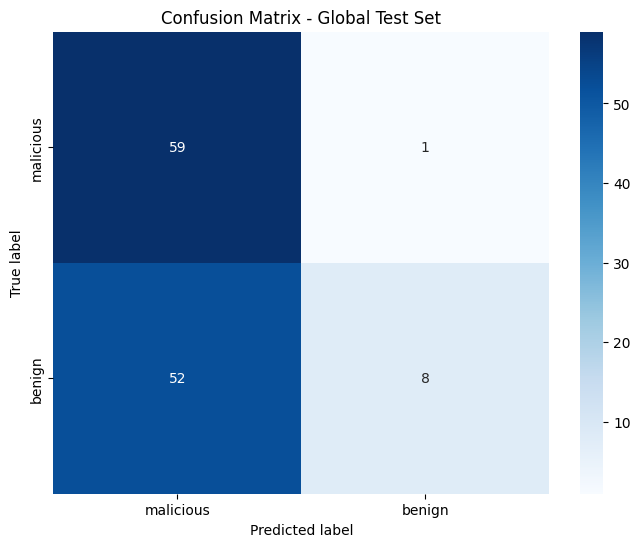

{'loss': 0.6985103636980057,
 'accuracy': 0.5583333333333333,
 'recall': 0.13333333333333333,
 'precision': 0.8888888888888888,
 'f1': 0.2318840579710145,
 'f2': 0.1606425702811245,
 'confusion_matrix': array([[59,  1],
        [52,  8]])}

In [ ]:
# Instantiate the FedAvg strategy for federated learning
strategy = FedAvg(
    fraction_fit=1.0,  # Use 100% of available clients for the fit (training) phase in each round
    fraction_evaluate=1.0,  # Use 100% of available clients for evaluation in each round
    min_fit_clients=3,  # Minimum number of clients required to be available for training in each round
    min_evaluate_clients=3,  # Minimum number of clients required to be available for evaluation in each round
    min_available_clients=3,  # Minimum number of clients that need to be connected to the server
    evaluate_metrics_aggregation_fn=weighted_average,  # Function to aggregate evaluation metrics across clients
)

# Run the federated learning simulation with the defined strategy and configurations
fl.simulation.start_simulation(
    client_fn=client_fn,  # Function to initialize a FlowerClient instance for each client
    num_clients=NUM_CLIENTS,  # Total number of clients participating in the simulation
    config=fl.server.ServerConfig(num_rounds=5),  # Server configuration with number of federated rounds
    strategy=strategy,  # The federated averaging strategy defined above
    client_resources=client_resources,  # Resources allocated to each client (e.g., CPUs, GPUs)
)

# After completing federated learning rounds, evaluate the global model on the global test set
global_evaluation_metrics = evaluate_global_model(global_model, global_test_loader)

**CORRECTED CONFUSION MATRIX** (by swapping rows and columns)

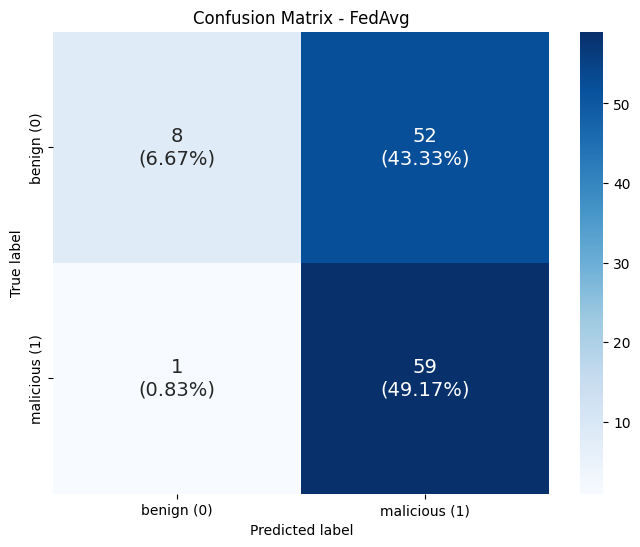

True Positives (TP): 59
False Positives (FP): 52
True Negatives (TN): 8
False Negatives (FN): 1
Accuracy: 0.5583
Precision: 0.5315
Recall: 0.9833
F1 Score: 0.6901
F2 Score: 0.8405


In [ ]:
def process_and_plot_confusion_matrix(test_cm, title="Confusion Matrix"):
    # Swap rows and columns to make 'Benign (0)' first and 'Malicious (1)' second
    corrected_cm = test_cm[[1, 0], :]  # Swap rows (True Labels)
    corrected_cm = corrected_cm[:, [1, 0]]  # Swap columns (Predicted Labels)

    # Define consistent class labels
    class_labels = ['benign (0)', 'malicious (1)']  # Benign first, Malicious second

    # Calculate relative distribution
    total = np.sum(corrected_cm)  # Total number of samples
    relative_cm = (corrected_cm / total) * 100  # Relative percentages

    # Plot the corrected confusion matrix with both values and percentages
    def plot_matrix(cm, relative_cm, class_labels, title):
        plt.figure(figsize=(8, 6))
        # Create a combined annotation (raw values + percentages)
        combined_annot = np.array([[f"{int(cm[i, j])}\n({relative_cm[i, j]:.2f}%)"
                                    for j in range(cm.shape[1])] for i in range(cm.shape[0])])

        sns.heatmap(cm, annot=combined_annot, fmt='', cmap=plt.cm.Blues,
                    xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
        plt.title(title)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    plot_matrix(corrected_cm, relative_cm, class_labels, title)

    # Extract TP, FP, FN, TN based on the new order
    TN = corrected_cm[0, 0]  # True Benign predicted as Benign
    FN = corrected_cm[1, 0]  # True Malicious predicted as Benign
    FP = corrected_cm[0, 1]  # True Benign predicted as Malicious
    TP = corrected_cm[1, 1]  # True Malicious predicted as Malicious

    # Recalculate metrics
    accuracy = (TP + TN) / total
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    f2 = (1 + 2**2) * (precision * recall) / ((4 * precision) + recall) if (precision + recall) != 0 else 0

    # Print the results
    # print(f"Metrics for {title}:")
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")

# Confusion Matrix
test_cm_2 = np.array([[59, 1],  # True: Malicious (1)
                      [52, 8]]) # True: Benign (0)
process_and_plot_confusion_matrix(test_cm_2, "Confusion Matrix - FedAvg")

**PLOTTING OF RESULTS**

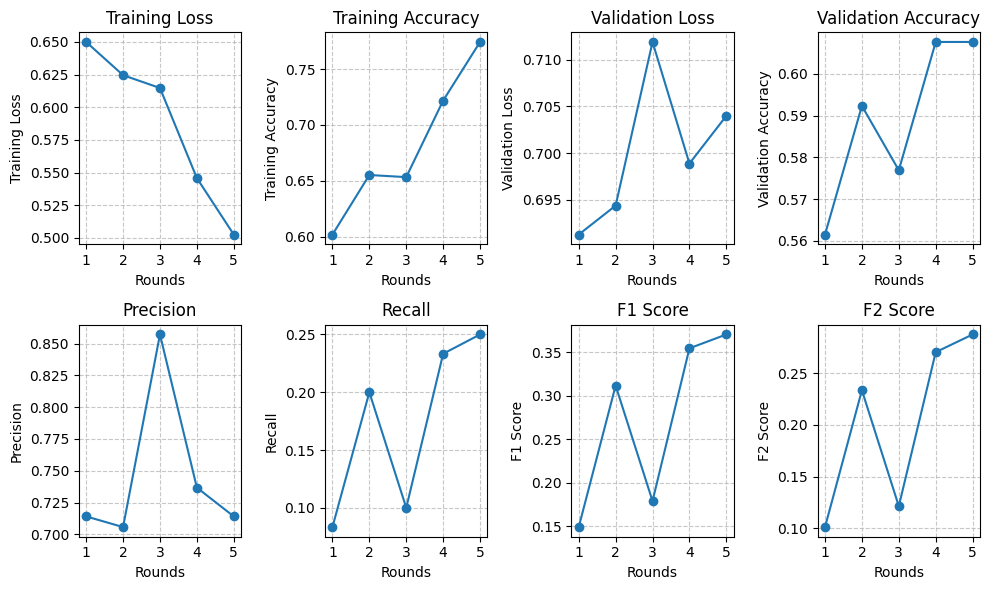

In [ ]:
# Data from the table
rounds = [1, 2, 3, 4, 5]
training_loss = [0.6499, 0.6245, 0.6147, 0.5458, 0.5026]
training_accuracy = [0.6019, 0.6552, 0.6533, 0.7218, 0.7742]
validation_loss = [0.6913, 0.6944, 0.7119, 0.6989, 0.7040]
validation_accuracy = [0.5615, 0.5923, 0.5769, 0.6076, 0.6076]
precision = [0.7142, 0.7058, 0.8571, 0.7368, 0.7142]
recall = [0.0833, 0.2000, 0.1000, 0.2333, 0.2500]
f1 = [0.1492, 0.3116, 0.1791, 0.3544, 0.3703]
f2 = [0.1012, 0.2334, 0.1214, 0.2702, 0.2873]

# Data and labels for the plots
metrics = [
    ("Training Loss", training_loss),
    ("Training Accuracy", training_accuracy),
    ("Validation Loss", validation_loss),
    ("Validation Accuracy", validation_accuracy),
    ("Precision", precision),
    ("Recall", recall),
    ("F1 Score", f1),
    ("F2 Score", f2),
]

# Create a 4x2 matrix of subplots without labels in legends
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, (title, data) in enumerate(metrics):
    ax = axes[i]
    ax.plot(rounds, data, marker='o', linestyle='-')
    ax.set_title(title)
    ax.set_xlabel("Rounds")
    ax.set_ylabel(title)
    ax.set_xticks(rounds)
    ax.grid(True, linestyle="--", alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


**FEDPROX STRATEGY**

In [ ]:
# Class Definition
class FlowerClient(fl.client.NumPyClient):
    """
    Custom client class for federated learning using the Flower framework.

    This class implements methods to manage a PyTorch model's lifecycle within a federated
    learning session, including setting parameters received from the server, training the model,
    and evaluating its performance.

    Attributes:
        net (torch.nn.Module): The PyTorch model to train and evaluate.
        trainloader (DataLoader): DataLoader for the training data.
        valloader (DataLoader): DataLoader for the validation data.
    """

# Constructor
    def __init__(self, net, client_loader, val_loader):
        """
        Initializes the FlowerClient instance with a network, training dataloader, and validation dataloader.

        Args:
            net (torch.nn.Module): The neural network model to train and evaluate.
            trainloader (DataLoader): DataLoader for the training dataset.
            valloader (DataLoader): DataLoader for the validation dataset.
        """
        self.net = net
        self.client_loader = client_loader
        self.val_loader = val_loader
        self.local_model = None  # Placeholder to store local model


# Methods
# Get Parameters
    def get_parameters(self, config):
        """
        Retrieves the current model parameters.

        This method is called by the Flower server to get the current weights from this client's model.

        Args:
             config (dict): Configuration parameters supplied by the Flower server, can be used to
                        customize parameter retrieval if needed.

        Returns:
             List[np.ndarray]: The current model parameters as a list of NumPy arrays.
        """
        return get_parameters(self.net)

    def fit(self, parameters, config):
        """
        Trains the model using the provided parameters and the local training data.

        This method sets the provided parameters to the model, performs training, and returns the updated parameters.

        Args:
            parameters (List[np.ndarray]): Parameters to be loaded into the model.
            config (dict): Configuration parameters supplied by the Flower server

        Returns:
            Tuple[NDArrays, int, Dict[str, Scalar]]: The updated model parameters, the number of examples used for training,
                                                 and a dictionary of training metrics (e.g., accuracy).
        """
        # Set model parameters
        set_parameters(self.net, parameters)

        # Train the model
        train_and_evaluate(self.net, self.client_loader, self.val_loader, test_loader=None, epochs=5, DEVICE=DEVICE)

        # Get the updated model parameters
        updated_parameters = get_parameters(self.net)

        # Calculate accuracy or other relevant metrics (you can add other metrics too)
        accuracy = self.calculate_accuracy(self.client_loader)

        # Return model parameters, number of examples, and metrics
        return updated_parameters, len(self.client_loader.dataset), {"accuracy": accuracy}

    def calculate_accuracy(self, loader):
        correct, total = 0, 0
        self.net.eval()

        with torch.no_grad():
            for data in loader:
                images, labels = data
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = self.net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total if total > 0 else 0
        return accuracy

# Evaluate
    def evaluate(self, parameters, config):
        """
        Evaluates the model on the local validation dataset.

        This method sets the provided parameters to the model and evaluates its performance.

        Args:
            parameters (List[np.ndarray]): Parameters to be loaded into the model.
            config (dict): Configuration parameters supplied by the Flower server

        Returns:
            tuple: A tuple containing the evaluation loss, the number of examples used for evaluation,
                  and a dictionary containing various performance metrics such as accuracy, recall,
                  precision, F1, and F2 scores.
        """
        set_parameters(self.net, parameters)   # Load the global parameters
        loss, accuracy, recall, precision, f1, f2, cm = test(self.net, self.val_loader, DEVICE)

        # Print metrics at the client level
        print(f"\nClient Validation Results:")   # Print client-level metrics
        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation Precision: {precision:.4f}")
        print(f"Validation Recall: {recall:.4f}")
        print(f"Validation F1 Score: {f1:.4f}")
        print(f"Validation F2 Score: {f2:.4f}")

        return float(loss), len(self.val_loader.dataset), {
            "accuracy": float(accuracy),
            "recall": float(recall),
            "precision": float(precision),
            "f1": float(f1),
            "f2": float(f2)
        }

    def get_local_model(self):
        # Function to retrieve local model state
        return self.local_model

**MODEL TRAINING AND EVALUATION**

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-09-21 19:26:46,773	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 16326673612.0, 'memory': 32653347227.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=37304) 2024-09-21 19:26:49.920777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=37304) 2024-09-21 19:26:49.963623: E external/local_xla/xla/st

(ClientAppActor pid=37307) Epoch 1/5, Training Loss: 0.7040, Training Accuracy: 0.5457, Validation Loss: 0.6869, Validation Accuracy: 0.6308, Val Precision: 0.7308, Val Recall: 0.3167, Val F1: 0.4419, Val F2: 0.3571
(ClientAppActor pid=37305) Epoch 1/5, Training Loss: 0.7041, Training Accuracy: 0.5486, Validation Loss: 0.7333, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000


(ClientAppActor pid=37305) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=37305)   _warn_prf(average, modifier, msg_start, len(result))
(ClientAppActor pid=37305)          [repeated 2x across cluster]
(ClientAppActor pid=37305) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=37306) Epoch 1/5, Training Loss: 0.6901, Training Accuracy: 0.5686, Validation Loss: 0.7059, Validation Accuracy: 0.5308, Val Precision: 0.3333, Val Recall: 0.0167, Val F1: 0.0317, Val F2: 0.0206
(ClientAppActor pid=37307) Epoch 2/5, Training Loss: 0.6110, Training Accuracy: 0.6429, Validation Loss: 0.6962, Validation Accuracy: 0.5923, Val Precision: 0.6842, Val Recall: 0.2167, Val F1: 0.3291, Val F2: 0.2510
(ClientAppActor pid=37305) Epoch 2/5, Training Loss: 0.6420, Training Accuracy: 0.6371, Validation Loss: 0.7051, Validation Accuracy: 0.5308, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000
(ClientAppActor pid=37307) Epoch 3/5, Training Loss: 0.6283, Training Accuracy: 0.6457, Validation Loss: 0.7086, Validation Accuracy: 0.5385, Val Precision: 0.5000, Val Recall: 0.0500, Val F1: 0.0909, Val F2: 0.0610 [repeated 2x across cluster]
(ClientAppActor pid=37307) Epoch 4/5, Training Loss: 0.6146, Training Accuracy: 0.6486, Validation Loss: 0.

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>


(ClientAppActor pid=37305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=37305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=37305)             entirely in future versions of Flower.
(ClientAppActor pid=37305) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=37305)   warnings.warn(
(ClientAppActor pid=37305) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weig

(ClientAppActor pid=37305) 
(ClientAppActor pid=37305) Client Validation Results:
(ClientAppActor pid=37305) Validation Loss: 0.7220
(ClientAppActor pid=37305) Validation Accuracy: 0.5462
(ClientAppActor pid=37305) Validation Precision: 0.6667
(ClientAppActor pid=37305) Validation Recall: 0.0333
(ClientAppActor pid=37305) Validation F1 Score: 0.0635
(ClientAppActor pid=37305) Validation F2 Score: 0.0412
(ClientAppActor pid=37305) Epoch 5/5, Training Loss: 0.6164, Training Accuracy: 0.6457, Validation Loss: 0.7218, Validation Accuracy: 0.5462, Val Precision: 1.0000, Val Recall: 0.0167, Val F1: 0.0328, Val F2: 0.0207


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=37307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=37307)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=37307)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=37307) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 3x across cluster]
(ClientAppActor pid=37307)   warnings.warn( [r

(ClientAppActor pid=37307) Epoch 1/5, Training Loss: 0.5928, Training Accuracy: 0.6600, Validation Loss: 0.7509, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000
(ClientAppActor pid=37307)  [repeated 2x across cluster]
(ClientAppActor pid=37307) Client Validation Results: [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation Loss: 0.7220 [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation Accuracy: 0.5462 [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation Precision: 0.6667 [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation Recall: 0.0333 [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation F2 Score: 0.0412 [repeated 4x across cluster]


(ClientAppActor pid=37307) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior. [repeated 2x across cluster]
(ClientAppActor pid=37307)   _warn_prf(average, modifier, msg_start, len(result)) [repeated 2x across cluster]


(ClientAppActor pid=37307) Epoch 2/5, Training Loss: 0.5503, Training Accuracy: 0.7486, Validation Loss: 0.7384, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000 [repeated 3x across cluster]


(ClientAppActor pid=37307) /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=37307)   _warn_prf(average, modifier, msg_start, len(result))


(ClientAppActor pid=37307) Epoch 3/5, Training Loss: 0.5351, Training Accuracy: 0.7629, Validation Loss: 0.7334, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000 [repeated 3x across cluster]
(ClientAppActor pid=37307) Epoch 4/5, Training Loss: 0.5192, Training Accuracy: 0.7657, Validation Loss: 0.7293, Validation Accuracy: 0.5462, Val Precision: 1.0000, Val Recall: 0.0167, Val F1: 0.0328, Val F2: 0.0207 [repeated 3x across cluster]
(ClientAppActor pid=37307) Epoch 5/5, Training Loss: 0.5365, Training Accuracy: 0.7371, Validation Loss: 0.7308, Validation Accuracy: 0.5462, Val Precision: 1.0000, Val Recall: 0.0167, Val F1: 0.0328, Val F2: 0.0207 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>


(ClientAppActor pid=37306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=37306) 
(ClientAppActor pid=37306)             This is a deprecated feature. It will be removed
(ClientAppActor pid=37306)             entirely in future versions of Flower.
(ClientAppActor pid=37306)         
(ClientAppActor pid=37306) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=37306)   warnings.warn(
(ClientAppActor pid=37306) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in

(ClientAppActor pid=37305) 
(ClientAppActor pid=37305) Client Validation Results:
(ClientAppActor pid=37305) Validation Loss: 0.7146
(ClientAppActor pid=37305) Validation Accuracy: 0.5462
(ClientAppActor pid=37305) Validation Precision: 0.5556
(ClientAppActor pid=37305) Validation Recall: 0.0833
(ClientAppActor pid=37305) Validation F1 Score: 0.1449
(ClientAppActor pid=37305) Validation F2 Score: 0.1004
(ClientAppActor pid=37306) Epoch 5/5, Training Loss: 0.5701, Training Accuracy: 0.6971, Validation Loss: 0.7148, Validation Accuracy: 0.5615, Val Precision: 0.6667, Val Recall: 0.1000, Val F1: 0.1739, Val F2: 0.1205 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=37306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=37306)          [repeated 6x across cluster]
(ClientAppActor pid=37306)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=37306)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=37306) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 

(ClientAppActor pid=37306)  [repeated 2x across cluster]
(ClientAppActor pid=37306) Client Validation Results: [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation Loss: 0.7146 [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation Accuracy: 0.5462 [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation Precision: 0.5556 [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation Recall: 0.0833 [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation F2 Score: 0.1004 [repeated 4x across cluster]
(ClientAppActor pid=37305) Epoch 1/5, Training Loss: 0.5456, Training Accuracy: 0.7229, Validation Loss: 0.7327, Validation Accuracy: 0.5385, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val F2: 0.0000
(ClientAppActor pid=37307) Epoch 1/5, Training Loss: 0.5518, Training Accuracy: 0.7686, Validation Loss: 0.7289, Validation Accuracy: 0.5462, Val Precision: 0.5385, Val Recall: 0.1167, Val F1: 0.1918, Val F2: 0.1383
(ClientAppAct

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>


(ClientAppActor pid=37305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=37305)          [repeated 2x across cluster]
(ClientAppActor pid=37305)             This is a deprecated feature. It will be removed
(ClientAppActor pid=37305)             entirely in future versions of Flower.
(ClientAppActor pid=37305) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=37305)   warnings.warn(
(ClientAppActor pid=37305) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

(ClientAppActor pid=37305) 
(ClientAppActor pid=37305) Client Validation Results:
(ClientAppActor pid=37305) Validation Loss: 0.6991
(ClientAppActor pid=37305) Validation Accuracy: 0.6077
(ClientAppActor pid=37305) Validation Precision: 0.5652
(ClientAppActor pid=37305) Validation Recall: 0.6500
(ClientAppActor pid=37305) Validation F1 Score: 0.6047
(ClientAppActor pid=37305) Validation F2 Score: 0.6311
(ClientAppActor pid=37305) Epoch 5/5, Training Loss: 0.4894, Training Accuracy: 0.7771, Validation Loss: 0.6814, Validation Accuracy: 0.7231, Val Precision: 0.7000, Val Recall: 0.7000, Val F1: 0.7000, Val F2: 0.7000 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=37306)          [repeated 6x across cluster]
(ClientAppActor pid=37306) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=37306)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=37306)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=37306) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 

(ClientAppActor pid=37306)  [repeated 2x across cluster]
(ClientAppActor pid=37306) Client Validation Results: [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation Loss: 0.6991 [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation Accuracy: 0.6077 [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation Precision: 0.5652 [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation Recall: 0.6500 [repeated 2x across cluster]
(ClientAppActor pid=37306) Validation F2 Score: 0.6311 [repeated 4x across cluster]
(ClientAppActor pid=37307) Epoch 1/5, Training Loss: 0.5519, Training Accuracy: 0.7343, Validation Loss: 0.7106, Validation Accuracy: 0.5923, Val Precision: 0.6000, Val Recall: 0.3500, Val F1: 0.4421, Val F2: 0.3818
(ClientAppActor pid=37306) Epoch 1/5, Training Loss: 0.5092, Training Accuracy: 0.7629, Validation Loss: 0.6957, Validation Accuracy: 0.5154, Val Precision: 0.4867, Val Recall: 0.9167, Val F1: 0.6358, Val F2: 0.7790
(ClientAppAct

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>


(ClientAppActor pid=37305)          [repeated 6x across cluster]
(ClientAppActor pid=37305) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=37305)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=37305)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=37305) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 3x across cluster]
(ClientAppActor pid=37305)   warnings.warn( [repeated 3x across cluster]
(ClientAppActor pid=37305) /usr/local/lib/python3.10/dist-packages/torchvi

(ClientAppActor pid=37305) 
(ClientAppActor pid=37305) Client Validation Results:
(ClientAppActor pid=37305) Validation Loss: 0.7013
(ClientAppActor pid=37305) Validation Accuracy: 0.4538
(ClientAppActor pid=37305) Validation Precision: 0.4567
(ClientAppActor pid=37305) Validation Recall: 0.9667
(ClientAppActor pid=37305) Validation F1 Score: 0.6203
(ClientAppActor pid=37305) Validation F2 Score: 0.7902
(ClientAppActor pid=37305) Epoch 5/5, Training Loss: 0.4500, Training Accuracy: 0.8371, Validation Loss: 0.7094, Validation Accuracy: 0.4692, Val Precision: 0.4634, Val Recall: 0.9500, Val F1: 0.6230, Val F2: 0.7851 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=37307)          [repeated 6x across cluster]
(ClientAppActor pid=37307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=37307)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=37307)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=37307) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 

(ClientAppActor pid=37307)  [repeated 2x across cluster]
(ClientAppActor pid=37307) Client Validation Results: [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation Loss: 0.7013 [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation Accuracy: 0.4538 [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation Precision: 0.4567 [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation Recall: 0.9667 [repeated 2x across cluster]
(ClientAppActor pid=37307) Validation F2 Score: 0.7902 [repeated 4x across cluster]
(ClientAppActor pid=37306) Epoch 1/5, Training Loss: 0.4766, Training Accuracy: 0.7829, Validation Loss: 0.7098, Validation Accuracy: 0.4385, Val Precision: 0.4381, Val Recall: 0.7667, Val F1: 0.5576, Val F2: 0.6667
(ClientAppActor pid=37305) Epoch 1/5, Training Loss: 0.4912, Training Accuracy: 0.7914, Validation Loss: 0.6976, Validation Accuracy: 0.4615, Val Precision: 0.4615, Val Recall: 1.0000, Val F1: 0.6316, Val F2: 0.8108
(ClientAppAct

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>
Client parameters type: <class 'flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy'>


(ClientAppActor pid=37307)          [repeated 6x across cluster]
(ClientAppActor pid=37307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=37307)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=37307)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=37307) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 3x across cluster]
(ClientAppActor pid=37307)   warnings.warn( [repeated 3x across cluster]
(ClientAppActor pid=37307) /usr/local/lib/python3.10/dist-packages/torchvi

(ClientAppActor pid=37305) 
(ClientAppActor pid=37305) Client Validation Results:
(ClientAppActor pid=37305) Validation Loss: 0.7031
(ClientAppActor pid=37305) Validation Accuracy: 0.4615
(ClientAppActor pid=37305) Validation Precision: 0.4615
(ClientAppActor pid=37305) Validation Recall: 1.0000
(ClientAppActor pid=37305) Validation F1 Score: 0.6316
(ClientAppActor pid=37305) Validation F2 Score: 0.8108
(ClientAppActor pid=37307) Epoch 5/5, Training Loss: 0.4577, Training Accuracy: 0.7800, Validation Loss: 0.6890, Validation Accuracy: 0.4615, Val Precision: 0.4615, Val Recall: 1.0000, Val F1: 0.6316, Val F2: 0.8108 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2127.61s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.7220226407051087
INFO :      		round 2: 0.7145976185798645
INFO :      		round 3: 0.6991341352462769
INFO :      		round 4: 0.7012862443923951
INFO :      		round 5: 0.7031009018421173
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.5461538461538461),
INFO :      	              (2, 0.5461538461538461),
INFO :      	              (3, 0.6076923076923076),
INFO :      	              (4, 0.45384615384615384),
INFO :      	              (5, 0.46153846153846156)],
INFO :      	 'f1': [(1, 0.06349206349206349),
INFO :      	        (2, 0.14492753623188406),
INFO :      	        (3, 0.6046511627906976),
INFO :      	        (4, 0.6203208556149733),
INFO :      	        (5, 0.6315789473684209)],
INFO :      	 'f2': [(1, 0.0411522633744856),
IN


Global Test Results:
Test Loss: 0.6985
Test Accuracy: 0.5583
Test Precision: 0.8889
Test Recall: 0.1333
Test F1 Score: 0.2319
Test F2 Score: 0.1606


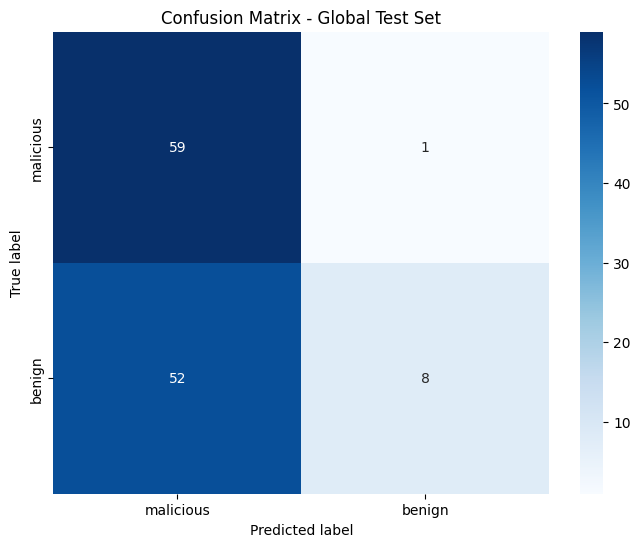

{'loss': 0.6985103636980057,
 'accuracy': 0.5583333333333333,
 'recall': 0.13333333333333333,
 'precision': 0.8888888888888888,
 'f1': 0.2318840579710145,
 'f2': 0.1606425702811245,
 'confusion_matrix': array([[59,  1],
        [52,  8]])}

In [ ]:
class FedProx(fl.server.strategy.FedAvg):
    def __init__(self, mu: float = 0.01, **kwargs):
        """
        Custom FedProx strategy extending FedAvg.

        Args:
            mu (float): Proximal term strength (higher values force client models to stay closer to the global model).
        """
        super().__init__(**kwargs)
        self.mu = mu

    def aggregate_fit(self, rnd, results, failures):
        """Aggregate fit results using FedProx logic."""
        # Use the FedAvg aggregation logic to get the aggregated parameters
        aggregated_parameters = super().aggregate_fit(rnd, results, failures)
        if aggregated_parameters is None:
            return None

        # Convert global parameters to numpy ndarrays for manipulation
        global_weights = parameters_to_ndarrays(aggregated_parameters[0])

        # Iterate over each client result
        for client_result in results:
            client_parameters, num_examples = client_result  # Tuple of (parameters, num_examples)

            # Debugging: Check the type of client_parameters
            print(f"Client parameters type: {type(client_parameters)}")

            # Ensure client_parameters is a Parameters object before continuing
            if not isinstance(client_parameters, fl.common.Parameters):
                print(f"Warning: client_parameters is not of type Parameters. It is of type {type(client_parameters)}")
                continue  # Skip this result as it is invalid

            # Convert client parameters to numpy arrays
            client_weights = parameters_to_ndarrays(client_parameters)

            # Apply the FedProx proximal term
            for i in range(len(client_weights)):
                client_weights[i] -= self.mu * (client_weights[i] - global_weights[i])

        # Convert the modified global weights back to a Parameters object
        updated_global_parameters = ndarrays_to_parameters(global_weights)

        return updated_global_parameters, aggregated_parameters[1]

# FedProx strategy configuration
strategy = FedProx(
    mu=0.01,  # Adjust the proximal term strength here
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=3,
    evaluate_metrics_aggregation_fn=weighted_average,  # Ensure weighted aggregation of metrics

)

# Simulation configuration
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources= client_resources,
)

# Evaluate the global model on the global test set after FL rounds
evaluate_global_model(global_model, global_test_loader)

**CORRECTED CONFUSION MATRIX** (by swapping rows and columns)

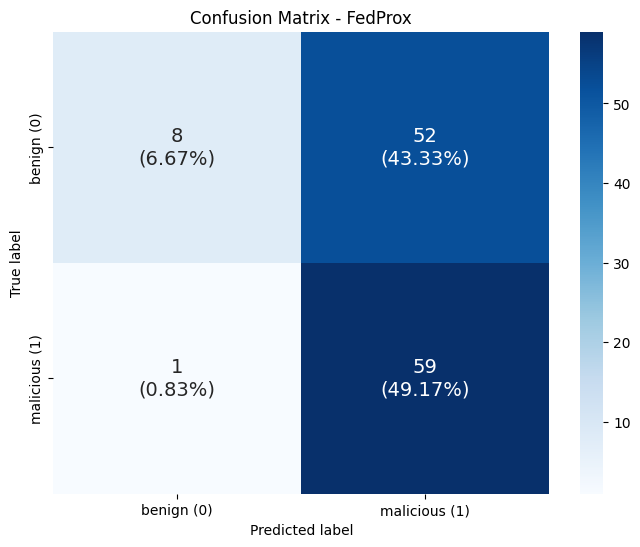

True Positives (TP): 59
False Positives (FP): 52
True Negatives (TN): 8
False Negatives (FN): 1
Accuracy: 0.5583
Precision: 0.5315
Recall: 0.9833
F1 Score: 0.6901
F2 Score: 0.8405


In [ ]:
def process_and_plot_confusion_matrix(test_cm, title="Confusion Matrix"):
    # Swap rows and columns to make 'Benign (0)' first and 'Malicious (1)' second
    corrected_cm = test_cm[[1, 0], :]  # Swap rows (True Labels)
    corrected_cm = corrected_cm[:, [1, 0]]  # Swap columns (Predicted Labels)

    # Define consistent class labels
    class_labels = ['benign (0)', 'malicious (1)']  # Benign first, Malicious second

    # Calculate relative distribution
    total = np.sum(corrected_cm)  # Total number of samples
    relative_cm = (corrected_cm / total) * 100  # Relative percentages

    # Plot the corrected confusion matrix with both values and percentages
    def plot_matrix(cm, relative_cm, class_labels, title):
        plt.figure(figsize=(8, 6))
        # Create a combined annotation (raw values + percentages)
        combined_annot = np.array([[f"{int(cm[i, j])}\n({relative_cm[i, j]:.2f}%)"
                                    for j in range(cm.shape[1])] for i in range(cm.shape[0])])

        sns.heatmap(cm, annot=combined_annot, fmt='', cmap=plt.cm.Blues,
                    xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
        plt.title(title)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    plot_matrix(corrected_cm, relative_cm, class_labels, title)

    # Extract TP, FP, FN, TN based on the new order
    TN = corrected_cm[0, 0]  # True Benign predicted as Benign
    FN = corrected_cm[1, 0]  # True Malicious predicted as Benign
    FP = corrected_cm[0, 1]  # True Benign predicted as Malicious
    TP = corrected_cm[1, 1]  # True Malicious predicted as Malicious

    # Recalculate metrics
    accuracy = (TP + TN) / total
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    f2 = (1 + 2**2) * (precision * recall) / ((4 * precision) + recall) if (precision + recall) != 0 else 0

    # Print the results
    # print(f"Metrics for {title}:")
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")

# Confusion Matrix
test_cm_2 = np.array([[59, 1],  # True: Malicious (1)
                      [52, 8]]) # True: Benign (0)
process_and_plot_confusion_matrix(test_cm_2, "Confusion Matrix - FedProx")

**PLOTTING OF RESULTS**

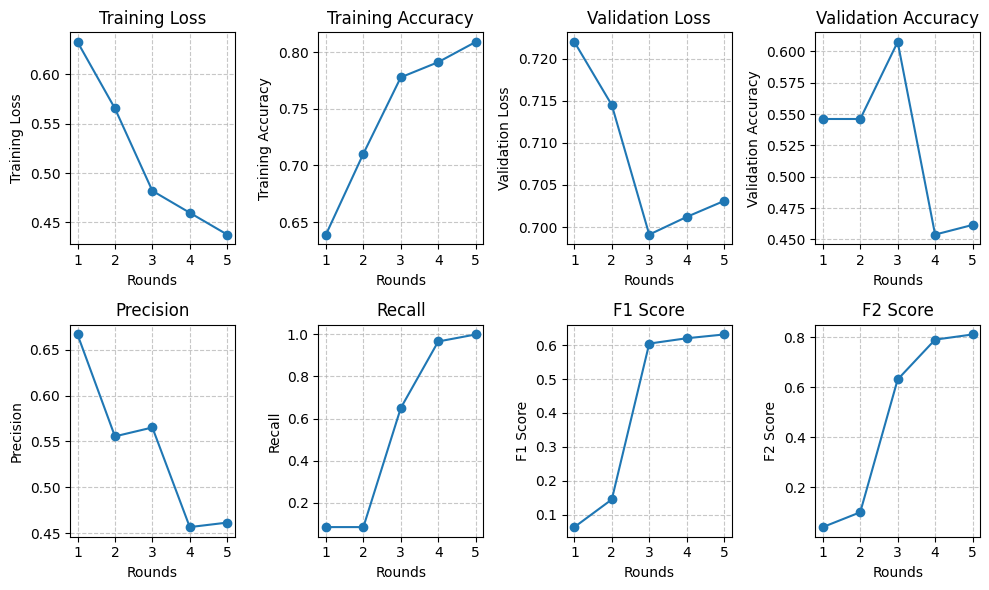

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
rounds = [1, 2, 3, 4, 5]
training_loss = [0.6327, 0.5654, 0.4820, 0.4598, 0.4377]
training_accuracy = [0.6390, 0.7104, 0.7778, 0.7912, 0.8090]
validation_loss = [0.7220, 0.7145, 0.6991, 0.7012, 0.7031]
validation_accuracy = [0.5461, 0.5461, 0.6076, 0.4538, 0.4615]
precision = [0.6666, 0.5555, 0.5652, 0.4566, 0.4615]
recall = [0.0833, 0.0833, 0.6500, 0.9666, 1.0000]
f1 = [0.0634, 0.1449, 0.6046, 0.6203, 0.6315]
f2 = [0.0411, 0.1004, 0.6310, 0.7901, 0.8108]

# Data and labels for the plots
metrics = [
    ("Training Loss", training_loss),
    ("Training Accuracy", training_accuracy),
    ("Validation Loss", validation_loss),
    ("Validation Accuracy", validation_accuracy),
    ("Precision", precision),
    ("Recall", recall),
    ("F1 Score", f1),
    ("F2 Score", f2),
]

# Create a 4x2 matrix of subplots without labels in legends
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, (title, data) in enumerate(metrics):
    ax = axes[i]
    ax.plot(rounds, data, marker='o', linestyle='-')
    ax.set_title(title)
    ax.set_xlabel("Rounds")
    ax.set_ylabel(title)
    ax.set_xticks(rounds)
    ax.grid(True, linestyle="--", alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
